# Components

```{glue:figure} NTR_components_stds
:scale: 50%
:align: right
```

In this notebook we'll explore the various contributions to high and low water levels. At the moment this is exploratory - we are using this to take broad stroke looks. We'll do this by breaking down the time series of hourly water levels at a tide gauge into different frequency bands, with the idea that certain processes fall within these timescales. For example, we know that ENSO timescales are roughly 4-7 years. We know that PDO timescales are closer to 20 years, and the timescale of mesoscale eddies the Hawaiian Island archipelago are 3 - 6 months. It's important to keep in mind that in this analysis we are not directly relating any of these processes to the observed sea levels at the tide gauges, but rather we are looking at _variability on similar timescales_. 

Thus, we're breaking sea level down into:

$\eta = \eta_{tide} + \eta_{t_N} + \eta_{NTR}$

where

$\eta_{NTR} = \eta_{ID} + \eta_{D} + \eta_{S} + \eta_{ItA} + \eta_{InA} + \eta_{W} + \eta_{HF}$

Note that $\eta_{tide}$ here is accounting for the nodal cycle modulation, and thus it is absent from the non-tidal residuals.

<!-- # make a dictionary of the timescales and the processes
timeframes = {'Interdecadal': '>30 yr cycles', 
              'Decadal': 'e.g. PDO, 8-30 yr', 
              'Seasonal': 'Annual, Semi-Annual, Qtr-Annual',
              'Interannual': 'e.g. ENSO, 1-8 yr', 
              'Intraannual': 'e.g. Mesoscale eddies', 
              'Weekly': '1 week - 2 months', 
              'Storms': '& other short-term variability',
              'Nodal': '18.6 yr tidal modulation'} -->


```{caution}
THIS IS VERY MUCH a work in progress and there are bound to be myriad errors. 
```

## Setup

In [1]:
%run setup.ipynb
%run plotting_functions.ipynb
%run tseries_functions.py
from tide_functions import calculate_ntr

print('hello')

hello


/opt/anaconda3/envs/SLI39/lib/python3.9/site-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/opt/anaconda3/envs/SLI39/lib/python3.9/site-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


## Obtain the Non-tidal Residual (NTR)

First we'll estimate the astronomical tides at this location using the selected epoch.

In [2]:
ds = xr.open_dataset(data_dir / 'rsl_pacific.nc')

# get the ntr for each station
calculate_ntr(ds)

Already processed 20 files:
[50, 52, 61, 57, 552, 52, 59, 25, 57, 552, 38, 25, 38, 58, 58, 59, 50, 60, 61, 60]


In [3]:
# load ntr data
station = 25
print('Doing station', station)
station_name = ds.station_name.sel(record_id=station).item()
print('Station name:', station_name)
mhhw = ds.MHHW.sel(record_id=station).item()
mllw = ds.MLLW.sel(record_id=station).item()
ntrpath = f'ntr_data/ntr_{station:03d}.csv'


ntr_data = pd.read_csv(Path(data_dir / ntrpath), parse_dates=['time'])

#inspect it, does it look sane?
ntr_data

Doing station 25
Station name: Funafuti


,time,ntr,sea_level,tide,nodal,ntr_withNodal
0,1993-03-24 01:00:00,-73.625333,1455.0,1528.625333,21.238390,-52.386943
1,1993-03-24 02:00:00,-17.467562,1850.0,1867.467562,22.495555,5.027993
2,1993-03-24 03:00:00,-62.135745,2193.0,2255.135745,14.750483,-47.385261
3,1993-03-24 04:00:00,-32.286236,2560.0,2592.286236,0.014125,-32.272111
4,1993-03-24 05:00:00,-49.111320,2744.0,2793.111320,-18.374460,-67.485780
...,...,...,...,...,...,...
279282,2025-01-31 19:00:00,15.942977,2970.0,2954.057023,-14.036157,1.906821
279283,2025-01-31 20:00:00,40.143703,2848.0,2807.856297,-0.500377,39.643326
279284,2025-01-31 21:00:00,30.529678,2517.0,2486.470322,12.268049,42.797727
279285,2025-01-31 22:00:00,89.383306,2165.0,2075.616694,22.411728,111.795034


### Plot and Inspect
We're looking at the NTR with and without the nodal modulation removed.

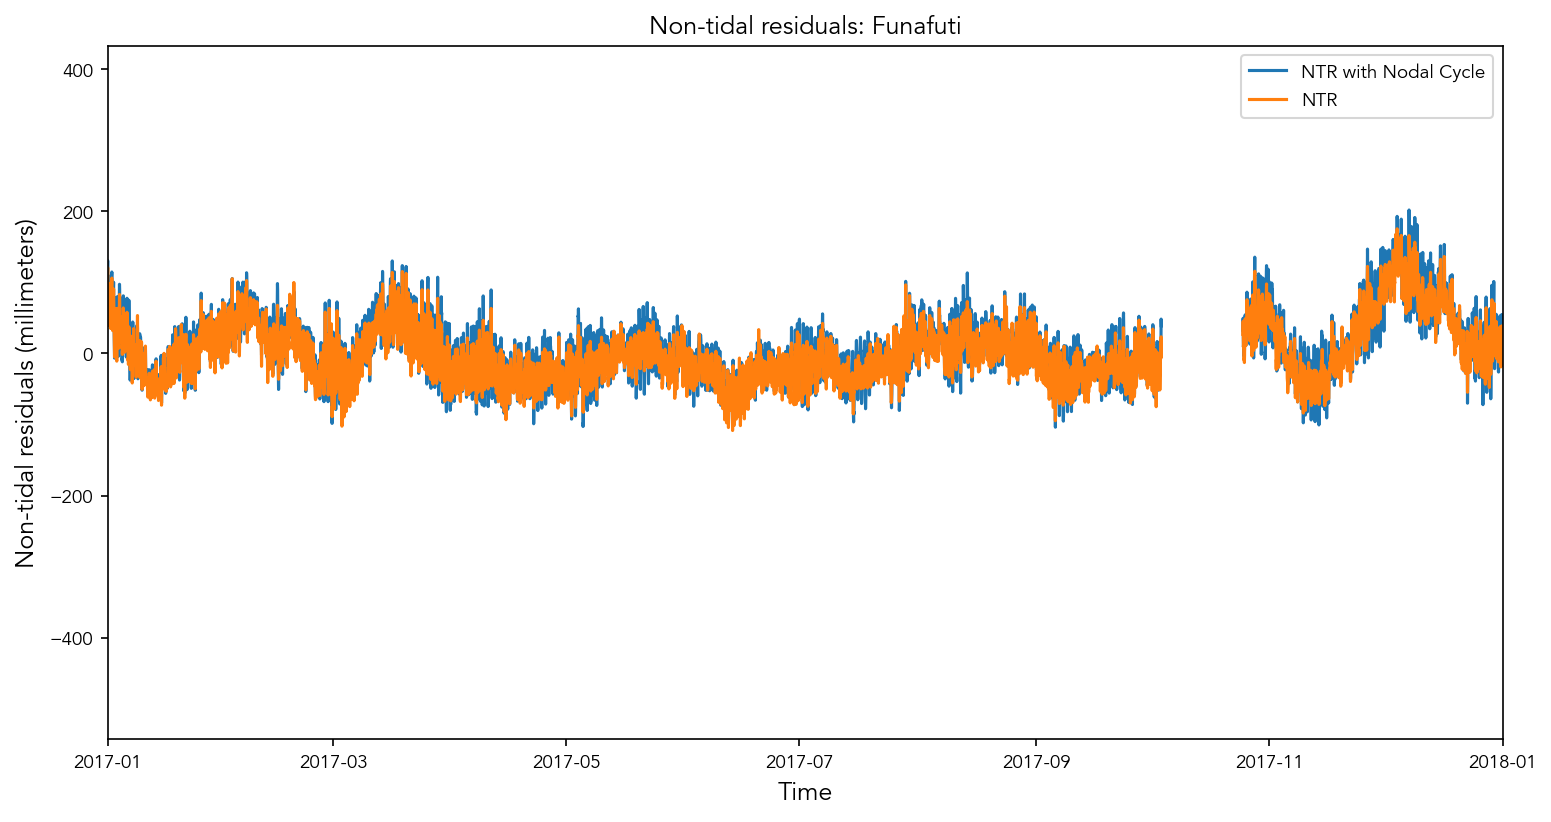

In [4]:
#plot time series
plt.figure(figsize=(12, 6))
plt.plot(ntr_data['time'], ntr_data['ntr_withNodal'], label='NTR with Nodal Cycle')
plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR')

# plt.plot(ntr_data['time'], ntr_data['nodal'], label='Nodal Cycle')

# add title
plt.title('Non-tidal residuals: ' + station_name)
plt.xlabel('Time')
plt.ylabel('Non-tidal residuals' + ' (' + ds['sea_level'].attrs['units'] + ')')

#set x-axis to 2000-2005
plt.xlim([np.datetime64('2017-01-01'), np.datetime64('2018-01-01')])
plt.legend()


### Let's examine the Nodal modulation a bit more
As noted by others studying the Honolulu tide gauge (e.g. Thompson et al), the modulation of the nodal cycle on the 99th percentile water levels can affect high sea levels by up to 5cm. In low-lying areas this contribution can be significant. Here, we'll simulate this effect by taking the upper envelope of the monthly max of the nodal modulation. 

In [5]:
# # Let's try treating the nodal cycle  in terms of its envelope - we'll use the Hilbert transform for this
import scipy.signal as signal

nodal = ntr_data['nodal'].copy()
# set index to time
nodal.index = ntr_data['time']
# resample nodal to monthly on the max
nodal_upper_envelope = nodal.resample('ME').max()
# 
# # Obtain the upper envelope of the nodal cycle using the amplitude of the Hilbert transform
analytic_signal = signal.hilbert(nodal_upper_envelope)
envelope = np.abs(analytic_signal)

envelope = pd.Series(envelope, index=nodal_upper_envelope.index)

# Shift the envelope 

# resample the envelope back to ntr_data time index
# envelope = envelope.reindex(ntr_data['time'], method='ffill')
# envelope = envelope.shift(periods=1, freq='15d')  # shift by 12 hours to align with the data

# interpolate the envelope to the ntr_data time index
envelope = envelope.reindex(ntr_data['time']).interpolate(method='linear')



(10957.0, 19783.0)

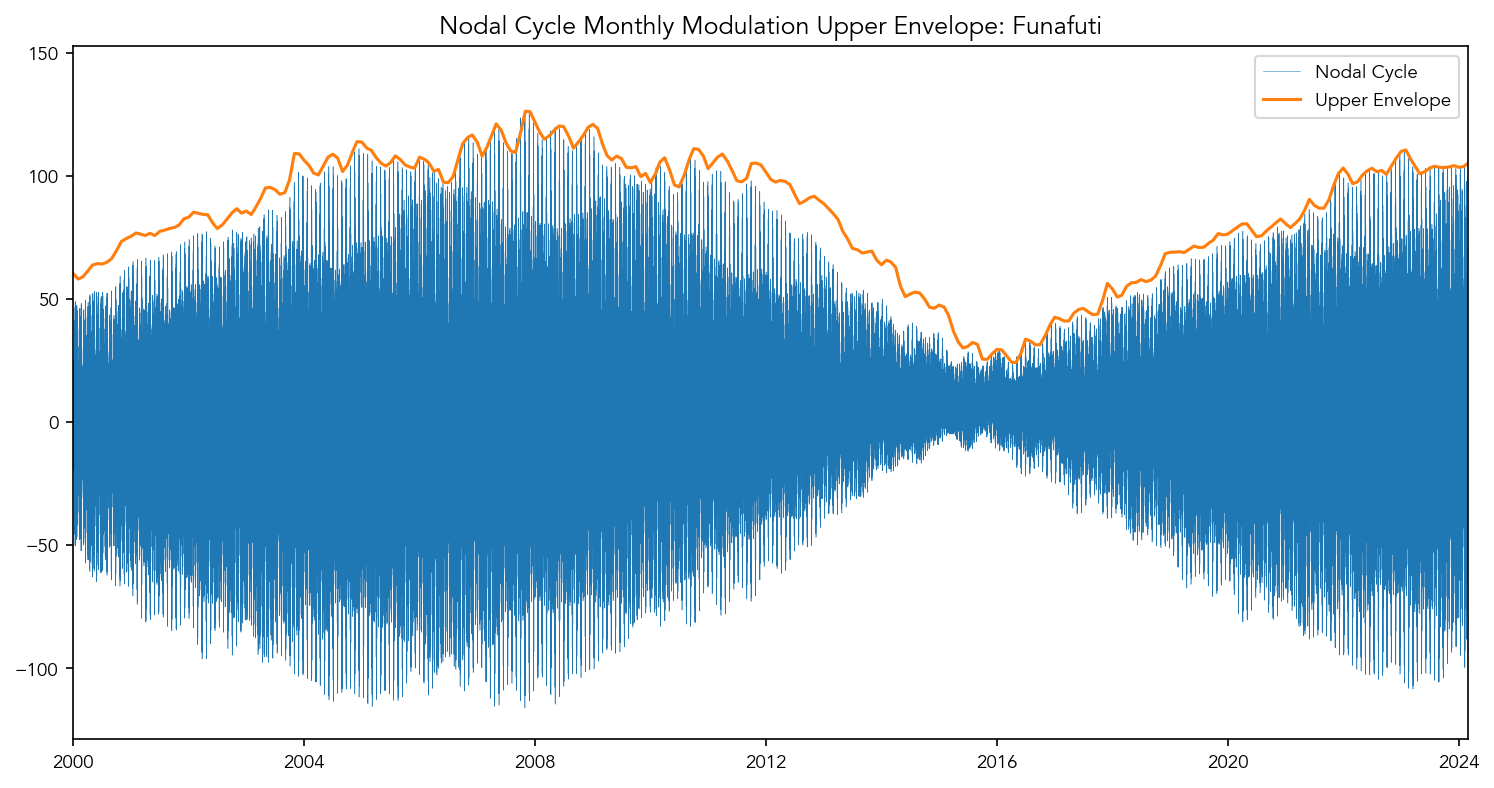

In [6]:
#plot the nodal signal and the envelope
plt.figure(figsize=(12, 6))
plt.plot(ntr_data['time'], ntr_data['nodal'], label='Nodal Cycle',linewidth=0.25)
plt.plot(envelope.index, envelope, label='Upper Envelope')
plt.title('Nodal Cycle Monthly Modulation Upper Envelope: ' + station_name)

plt.legend()
#set x-axis to 2017-2018
plt.xlim([np.datetime64('2000-01-01'), np.datetime64('2024-03-01')])

In [7]:
# ntr_data['time'] = pd.to_datetime(ntr_data['time'])
# ntr_data = ntr_data.set_index('time')
#make subset dataframe of ntr data with just ntr and time
sea_level_data = ntr_data[['ntr','time']].copy()
# sea_level_data['time'] = ntr_data['time']
ntr_data_mags,ntr_trend_series,ntr_trend_rates = process_trend_with_nan(sea_level_data)
# sea_level_data
ntr_data['ntr_detrended'] = ntr_data['ntr'] - ntr_trend_series['ntr']

Text(0, 0.5, 'Non-tidal residuals (millimeters)')

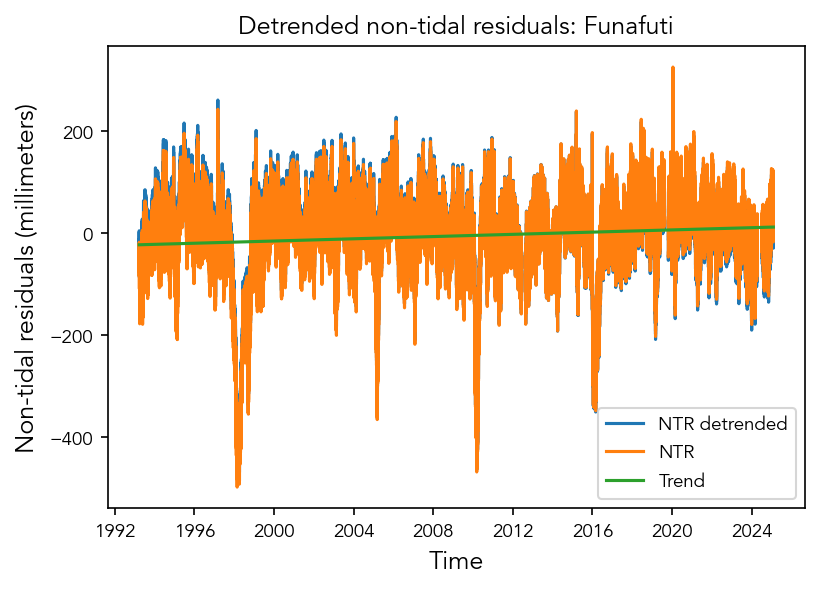

In [8]:
plt.plot(ntr_data['time'], ntr_data['ntr_detrended'], label='NTR detrended')
plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR')
plt.plot(ntr_data['time'], ntr_trend_series['ntr'], label='Trend')
plt.legend()

# add title
plt.title('Detrended non-tidal residuals: ' + station_name)
plt.xlabel('Time')
plt.ylabel('Non-tidal residuals' + ' (' + ds['sea_level'].attrs['units'] + ')')

#set x-axis to 2001 Jan to Feb
# plt.xlim([np.datetime64('2017-10-01'), np.datetime64('2017-10-02')])

# set y-axis to -0.1 to 0.1
# plt.ylim([0,200])

In [9]:
# Now start to filter for each frequency band we want

# make time_diffs in hours
time_diffs = np.diff(ntr_data['time']).astype('timedelta64[h]').astype(int)
widthSeasonal = 1/365.25/10; #1 cycle per decade



In [10]:
# # print the length of each segment and the start and end times
# for i in range(len(segments)):
#     print(f'Segment {i}: {len(segments[i])} points, {segments[i].time.iloc[0]} to {segments[i].time.iloc[-1]}')

In [11]:
# filtered_segments = filter_segments(segments,value_column='ntr_detrended',freq_cutoff=1/(365.25*20),order=4)

```{caution}
The timescales probably need some refinement. For example: mesoscale processes. Higher the latitude the longer the period!!
```
From Chen, S., and B. Qiu (2010), Mesoscale eddies northeast of the Hawaiian archipelago from satellite altimeter observations, J. Geophys. Res., 115, C03016, doi:10.1029/2009JC005698


"We define dominant periods of the mesoscale eddy activity by locating the periods at which the spectral peaks within the mesoscale range of 90–180 days. This definition is crude yet robust for the subregions with sharp spectral peaks like the 24°N–27°N, 160°W–155°W one (130 days) and the 18°N–21°N, 170°W–165°W one (90 days), but is also applicable to other subregions. In the lee of the island of Hawaii, 90 day oscillations dominate the mesoscale eddy activity. In the subregions between 24°N and 30°N, a 130 day peak often prevails, but in the 30°N–33°N band, a weak 180 day peak emerges. The pattern is that the higher the latitude, the longer the dominant period."

Also:
Firing, Y. L., and M. A. Merrifield (2004), Extreme sea level events at Hawaii: Influence of mesoscale eddies, Geophys. Res. Lett., 31, L24306, doi:10.1029/2004GL021539.

In [12]:
# Define timescales (in days)
annual = 365.25
semiannual = 365.25/2
qtrannual = 365.25/4
weekly = 7
bimonthly = 2*365.25/12
decadal = 8*365.25
interdecadal = 30*365.25


# make a dictionary of the timescales and the processes
timeframes = {'Interdecadal': '>30 yr cycles', 
              'Decadal': 'e.g. PDO, 8-30 yr', 
              'Seasonal': 'Annual, Semi-Annual, Qtr-Annual',
              'Interannual': 'e.g. ENSO, 1-8 yr', 
              'Intraannual': 'e.g. Mesoscale eddies', 
              'Weekly': '1 week - 2 months', 
              'Storms & HF': '& other short-term variability',
              'Nodal': '18.6 yr tidal modulation'}

# get frequency of annual cycle
# annual_freq = 1/annual

In [13]:

def filter_ntr(ntr_data):
    ntr_noAnnual, ntr_Annual = filter_known_frequency_components(ntr_data['ntr_detrended'], time_diffs,1/annual , width=widthSeasonal)
    ntr_noSemiAnnual, ntr_SemiAnnual = filter_known_frequency_components(ntr_noAnnual, time_diffs, 1/semiannual, width=widthSeasonal)
    ntr_noQtrAnnual, ntr_QtrAnnual = filter_known_frequency_components(ntr_noSemiAnnual, time_diffs, 1/qtrannual, width=widthSeasonal)
    ntr_Seasonal = ntr_Annual + ntr_SemiAnnual + ntr_QtrAnnual

    #interdecadal
    ntr_interdecadal, ntr_highFreq = butterworth_lowpass(ntr_noQtrAnnual, time_diffs, 1/interdecadal, order=3, padtype='even', padlen=3)

    #decadal
    ntr_decadal, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/decadal, order=3) 

    #interannual
    ntr_interannual, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/annual, order=4)

    # intraannual
    ntr_intraannual, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/bimonthly, order=5)

    # Remove high frequencies (weekly to hourly)
    # ntr_weekly is timescales longer than 7 days but less than 1 month
    ntr_weekly, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/weekly, order=5)

    # make dataframe of filtered data
    ntr_filtered = pd.DataFrame({'time': ntr_data['time'], 
                             'ntr': ntr_data['ntr_detrended'], 
                             'sea_level': ntr_data['sea_level'],
                             'tide': ntr_data['tide'],
                             'Nodal': ntr_data['nodal'],
                             'Interdecadal': ntr_interdecadal, 
                             'Decadal': ntr_decadal, 
                             'Interannual': ntr_interannual, 
                             'Seasonal': ntr_Seasonal, 
                             'Intraannual': ntr_intraannual, 
                             'Weekly': ntr_weekly, 
                             'Storms & HF': ntr_highFreq})


    return ntr_filtered


In [14]:
ntr_filtered = filter_ntr(ntr_data)

# get std of each component
ntr_component_stds = ntr_filtered.std()

# remove time from ntr)component_stds
ntr_component_stds = ntr_component_stds.drop('time')

Filled 4 % of data with noise (std = 80.3120).
Filled 4 % of data with noise (std = 77.6958).
Filled 4 % of data with noise (std = 75.9670).
Filled 4 % of data with noise (std = 75.7065).


In [15]:
# save ntr_component_stds to csv
savepath = Path(data_dir, f'ntr_data/ntr_{station:03d}_component_stds.csv')
ntr_component_stds.to_csv(savepath)


In [16]:
# look at filtered components of nodal cycle only
nodal_data = ntr_data.copy()
nodal_data.index = ntr_data['time']
envelope_demeaned = envelope - np.nanmean(envelope)
envelope_demeaned.index = nodal_data.index
nodal_data['ntr_detrended'] = envelope_demeaned
nodal_filtered = filter_ntr(nodal_data)

#rename "ntr" in nodal_filtered to "nodal upper envelope"
nodal_filtered = nodal_filtered.rename(columns={'ntr': 'nodal envelope'})

nodal_component_std = nodal_filtered.std() 
nodal_component_std = nodal_component_std.drop('time')



Filled 0 % of data with noise (std = 28.3801).
Filled 0 % of data with noise (std = 28.3146).
Filled 0 % of data with noise (std = 28.2933).
Filled 0 % of data with noise (std = 28.2917).


In [17]:
ntr_filtered

,time,ntr,sea_level,tide,Nodal,Interdecadal,Decadal,Interannual,Seasonal,Intraannual,Weekly,Storms & HF
0,1993-03-24 01:00:00,-51.181398,1455.0,1528.625333,21.238390,-1.803266,-22.129194,-14.339039,2.002513,-4.946454,-4.754877,-5.211081
1,1993-03-24 02:00:00,4.976249,1850.0,1867.467562,22.495555,-1.803249,-22.126116,-14.336602,1.988565,-4.873931,-4.524389,50.651970
2,1993-03-24 03:00:00,-39.692058,2193.0,2255.135745,14.750483,-1.803231,-22.123038,-14.334164,1.974599,-4.801270,-4.292661,5.687706
3,1993-03-24 04:00:00,-9.842673,2560.0,2592.286236,0.014125,-1.803214,-22.119959,-14.331725,1.960615,-4.728470,-4.059909,35.239989
4,1993-03-24 05:00:00,-26.667882,2744.0,2793.111320,-18.374460,-1.803196,-22.116881,-14.329286,1.946613,-4.655532,-3.826354,18.116755
...,...,...,...,...,...,...,...,...,...,...,...,...
279282,2025-01-31 19:00:00,3.698385,2970.0,2954.057023,-14.036157,-0.435990,10.643944,-26.343566,2.071977,61.291865,-31.516265,-12.013580
279283,2025-01-31 20:00:00,27.898986,2848.0,2807.856297,-0.500377,-0.435990,10.643944,-26.343566,2.058122,61.291865,-31.516329,12.200940
279284,2025-01-31 21:00:00,18.284837,2517.0,2486.470322,12.268049,-0.435990,10.643944,-26.343566,2.044247,61.291865,-31.516378,2.600715
279285,2025-01-31 22:00:00,77.138341,2165.0,2075.616694,22.411728,-0.435990,10.643944,-26.343566,2.030354,61.291865,-31.516416,61.468150


In [18]:
ntr_component_stds

ntr              80.312141
sea_level       475.137279
tide             470.28267
Nodal            28.348202
Interdecadal      0.591677
Decadal          16.825801
Interannual      49.896996
Seasonal         22.225112
Intraannual      33.136991
Weekly           24.530909
Storms & HF      25.693085
dtype: object

Text(0.5, 1.0, 'Correlation Matrix\n of upper nodal envelope components')

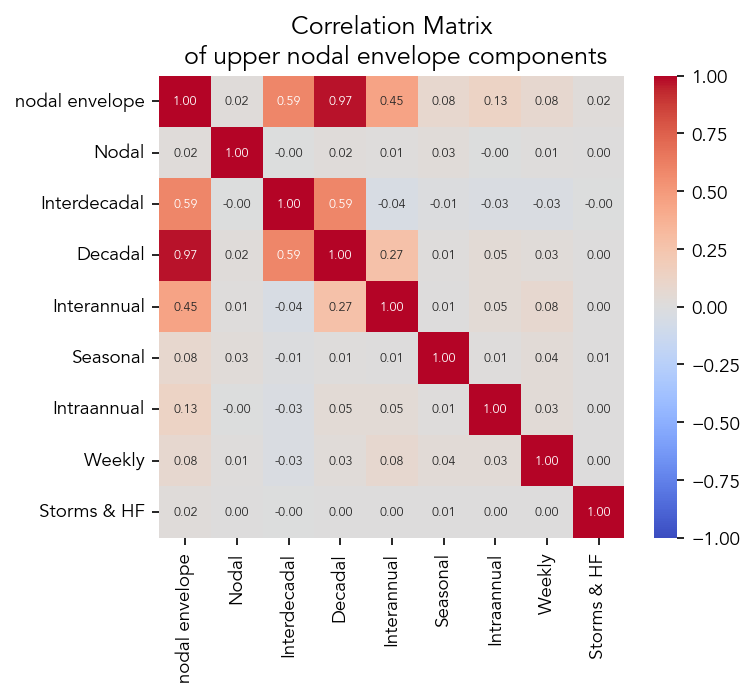

In [19]:
nodal_component_std
nodal_corr = nodal_filtered.drop(['time','sea_level','tide'], axis=1).corr()
#plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(nodal_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 6})
plt.title('Correlation Matrix\n of upper nodal envelope components')

Note that to define the upper envelope we used monthly maxima. So there should be NO correlation in the weekly/storms.

Next, a sanity check to make sure that everything adds up to the right sum.

Text(0, 0.5, 'Sum of components')

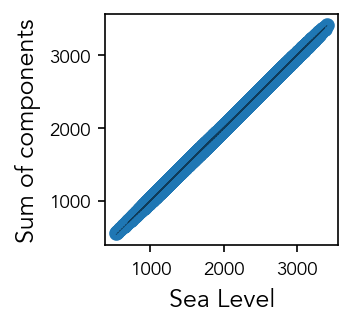

In [20]:
#plot ntr, then plot summed components
plt.figure(figsize=(2, 2))
ntr_sum = (ntr_filtered['Interdecadal']+
         ntr_filtered['Decadal']+
         ntr_filtered['Interannual']+
         ntr_filtered['Seasonal']+
         ntr_filtered['Intraannual']+
         ntr_filtered['Weekly']+
         ntr_filtered['Storms & HF'] +
         ntr_filtered['tide'])
#make a dotted 1:1 line
plt.plot(ntr_filtered['sea_level'], ntr_filtered['sea_level'], 'k:', label='1:1 line',linewidth=0.5,alpha=0.5)
plt.scatter(ntr_filtered['sea_level'], ntr_sum)

plt.xlabel('Sea Level')
plt.ylabel('Sum of components')


In [21]:
#export data
# ntr_filtered.to_csv('data/ntr_filtered_059b.csv', index=False)

Text(0.5, 1.0, 'Correlation between each component')

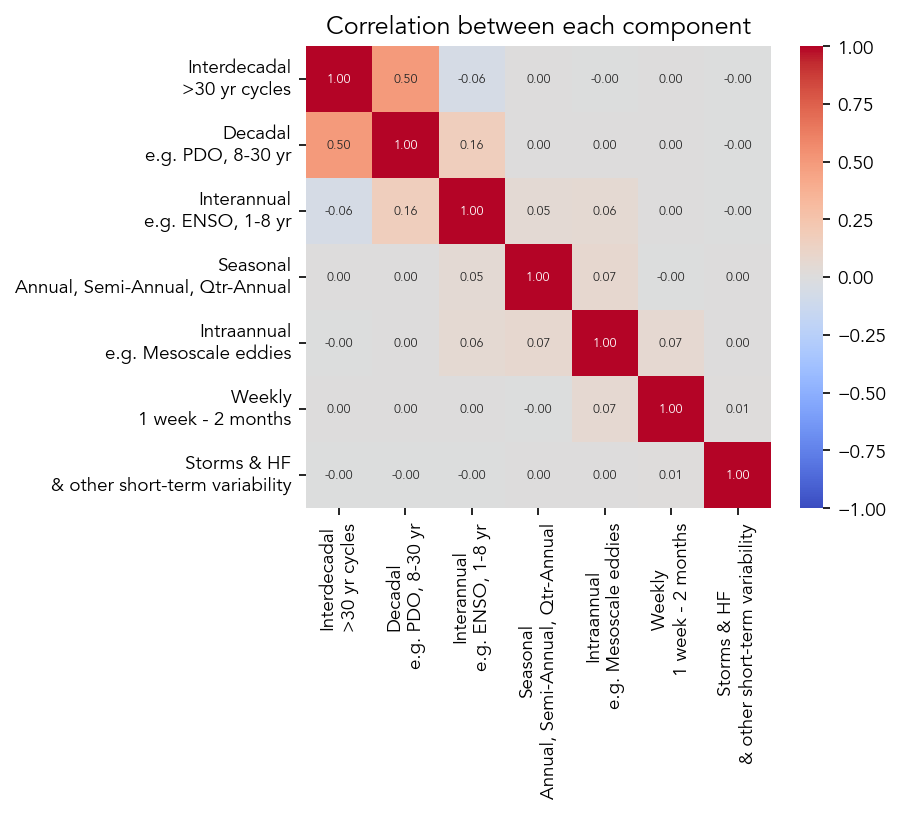

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

#make a heatmap plot of correlation between each component
ntr_corr = ntr_filtered.drop(['time','sea_level','tide','ntr','Nodal'], axis=1).corr()

# add description to each component in ntr correlation matrix
ntr_corr.columns = [col + '\n' + timeframes[col] for col in ntr_corr.columns]
ntr_corr.index = [col + '\n' + timeframes[col] for col in ntr_corr.index]
#exclude time,sea_level, and tide from the correlation matrix

#plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(ntr_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 6})
plt.title('Correlation between each component')



Note there is correlation between some of these timeseries, likely due to the filtering process employed in this notebook. 

In [23]:
# get the cumulative sum of the components
ntr_cumsum = ntr_filtered[['Interdecadal', 'Decadal', 'Interannual', 'Seasonal', 'Intraannual', 'Weekly', 'Storms & HF']].cumsum(axis=1)
ntr_cumsum_stds = ntr_cumsum.std()
ntr_cumsum_stds
# make a plot of ntr_filtered and ntr_cumsum
# fig, ax = plt.subplots(figsize=(12, 6))
# ntr_filtered.plot(x='time', y=['ntr'], ax=ax, color=['black'], linewidth=1)
# ntr_filtered_sums.plot(x='time', y=['Nodal'] +['> 20 years'], ax=ax, color='yellow',linewidth=1, linestyle='--')
# ntr_cumsum.plot(x='time', y=['Nodal', '> 20 years'], ax=ax, linewidth=1, linestyle='--')
# ntr_cumsum.plot(x='time', y=['Nodal', '> 20 years', '10-20 year', '1-10 year', 'Seasonal', '1 month - 1 year', '1 week - 1 month', '< 1 week'], ax=ax, linewidth=1, linestyle='--')


Interdecadal     0.591677
Decadal         17.127071
Interannual     55.276129
Seasonal        61.219698
Intraannual     71.005491
Weekly          75.825775
Storms & HF     80.165663
dtype: float64

In [24]:
ntr_filtered.keys()

Index(['time', 'ntr', 'sea_level', 'tide', 'Nodal', 'Interdecadal', 'Decadal',
       'Interannual', 'Seasonal', 'Intraannual', 'Weekly', 'Storms & HF'],
      dtype='object')

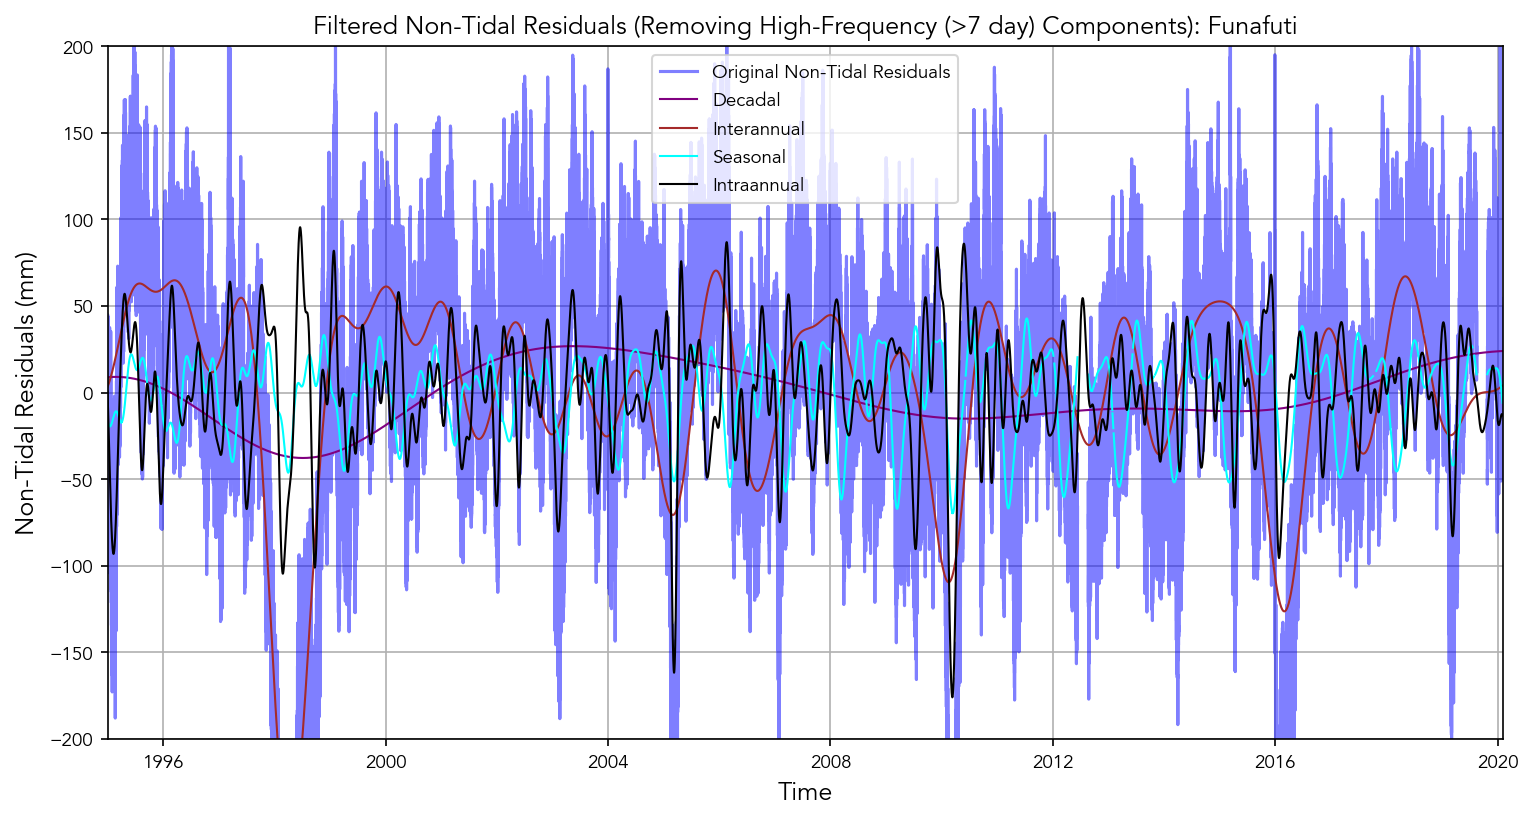

In [25]:
# Plot original vs. filtered signal
plt.figure(figsize=(12, 6))
plt.plot(ntr_filtered['time'], ntr_filtered['ntr'], label='Original Non-Tidal Residuals', color ="blue",alpha=0.5)
# plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='$NTR - NTR_{hf}$', color='orange', linewidth=2)

# ntr_summed = ntr_Annual + ntr_SemiAnnual + ntr_QtrAnnual + ntr_subAnnual + ntr_multiyear + ntr_decadal + ntr_lowFreq + ntr_monthly
# ntr_summed = ntr_filtered['Nodal']+ ntr_filtered['> 20 years'] + ntr_filtered['10-20 year'] + ntr_filtered['1-10 year'] + ntr_filtered['Seasonal'] + ntr_filtered['1 month - 1 year'] + ntr_filtered['1 week - 1 month'] + ntr_filtered['< 1 week']

# plt.plot(ntr_filtered['time'], ntr_summed, label='Sum of Filtered Components', color='red', linewidth=1)

# plt.plot(ntr_filtered['time'], ntr_filtered['Nodal']+ntr_filtered['nodal_utide'], label='Nodal', color='green', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='> 20 years', color='orange', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Decadal'], label='Decadal', color='purple', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Interannual'], label='Interannual', color='brown', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Seasonal'], label='Seasonal', color='cyan', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Intraannual'], label='Intraannual', color='black', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['1 week - 2 month'], label='1 week - 2 month', color='pink', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['< 1 week'], label='< 1 week', color='grey', linewidth=1)

plt.xlabel('Time')
plt.ylabel('Non-Tidal Residuals (mm)')
plt.title('Filtered Non-Tidal Residuals (Removing High-Frequency (>7 day) Components): ' + station_name)
plt.legend()
plt.grid()

# change xlim to zoom in
plt.xlim(pd.Timestamp('1995-01-01'), pd.Timestamp('2020-02-01'))
plt.ylim(-200, 200)
plt.show()

In [26]:
ntr_component_stds
# save to csv

ntr              80.312141
sea_level       475.137279
tide             470.28267
Nodal            28.348202
Interdecadal      0.591677
Decadal          16.825801
Interannual      49.896996
Seasonal         22.225112
Intraannual      33.136991
Weekly           24.530909
Storms & HF      25.693085
dtype: object

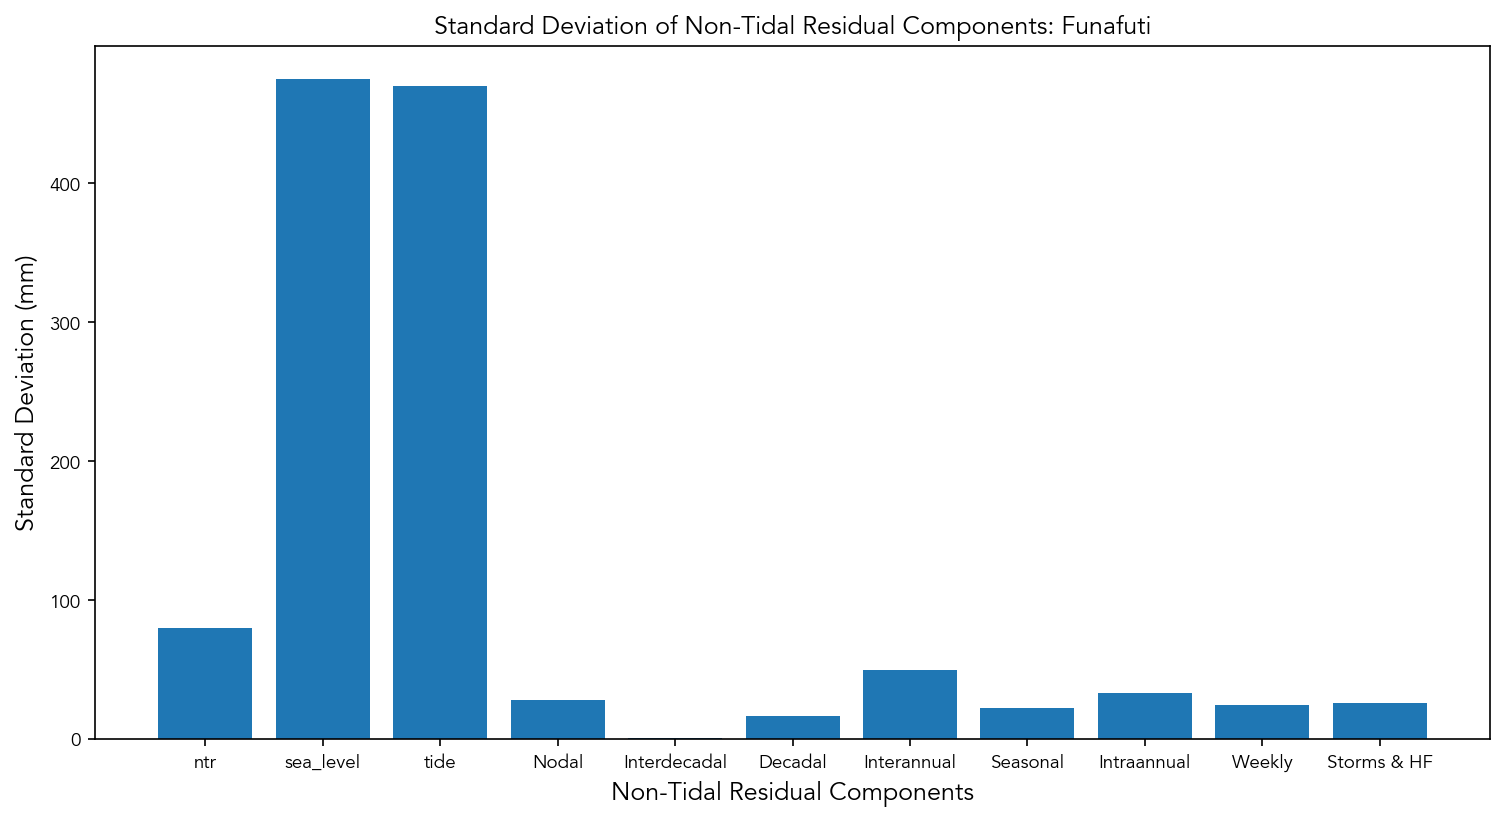

In [27]:
#make a bar plot of the std of each component
import textwrap

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(ntr_component_stds.index, ntr_component_stds)
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=12)) for label in ntr_component_stds.index]
plt.xticks(range(len(ntr_component_stds.index)), wrapped_labels)
# plt.xticks(rotation=45)
ax.set_xlabel('Non-Tidal Residual Components')
ax.set_ylabel('Standard Deviation (mm)')
ax.set_title('Standard Deviation of Non-Tidal Residual Components: ' + station_name)


plt.show()

## Plot components
Make a bar plot of average contributions to water levels.

/var/folders/qp/nn19rcjs5bdcdvxmff5bd3pr0000gn/T/ipykernel_6826/3394451137.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.bar('Components', 0.4*ntr_cumsum_stds[i], bottom=0, label=ntr_cumsum_stds.index[i].replace('\n', ' '))


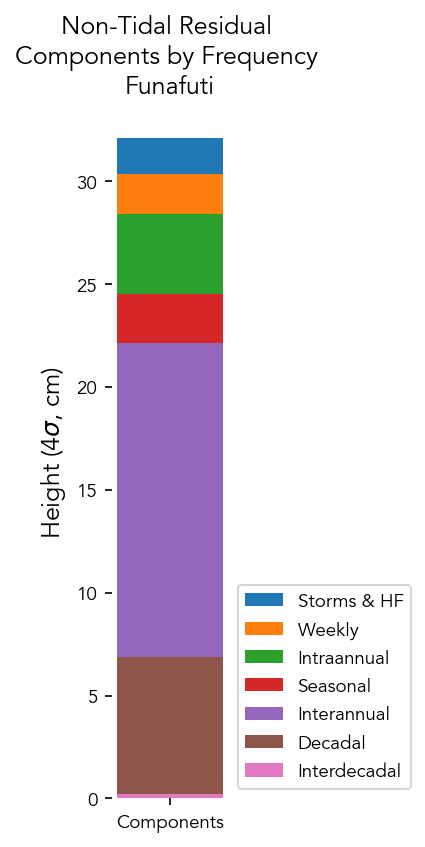

In [28]:
# Create figure
fig, ax = plt.subplots(figsize=(1, 6))

# Plot stacked bars
bottom = 0
for i in range(len(ntr_cumsum_stds.index)-1, -1, -1):
    ax.bar('Components', 0.4*ntr_cumsum_stds[i], bottom=0, label=ntr_cumsum_stds.index[i].replace('\n', ' '))

# ax.bar('Total NTR', np.std(ntr_filled), color='white', edgecolor='black', linewidth=1)

# Labels and title
ax.set_ylabel('Height (4$\sigma$, cm)')
ax.set_title('Non-Tidal Residual \nComponents by Frequency \n' + station_name)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# no box
for spine in ax.spines.values():
    spine.set_visible(False)

figName = 'NTR_components_stds' + station_name
glue('NTR_components_stds',fig,display=False)


In [29]:
station

25

It's important to note that in the plot above, we're looking at the $4\sigma$, which is akin to 'significant wave height.' Nor do we consider each $\sigma$ independently in this plot, but instead we compute the standard deviation of the combined signals, as we work our way up to higher and higher frequencies. For example, the purple line above shows the contributions of any cycles that occur on timescales longer than 1 year. Each individual componenent has its own standard deviation but none are truly indepedent signals (due to the filtering mechanism here) and therefore the variances cannot be directly added together to represent the total variances of the whole signal. (See the correlation plot above.)

In [30]:
# get dates of extreme events
station_name_1st = station_name.split(',')[0]
top10tableName = 'SL_top_10_table_' + station_name_1st + '.csv'

#temporarily set the output_dir to ../output
# output_dir = Path('../output')
extremes_csv = Path(output_dir, top10tableName)
extremes = pd.read_csv(extremes_csv)

In [31]:
extremes

,Rank,Highest,Highest Date,Highest ONI Mode,Lowest,Lowest Date,Lowest ONI Mode,Zone,ONI max,ONI min
0,1,0.672,2006-02-28 05:00,La Nina,-2.212,1998-02-27 12:00,El Nino,GMT,-0.57,1.44
1,2,0.634,2023-02-20 05:00,Neutral,-2.194,1998-03-27 11:00,El Nino,GMT,-0.15,0.99
2,3,0.630,2024-03-10 05:00,El Nino,-2.110,1998-04-26 11:00,Neutral,GMT,1.14,0.45
3,4,0.626,2020-03-10 06:00,Neutral,-2.059,1998-01-29 12:00,El Nino,GMT,0.40,1.93
4,5,0.624,2015-02-19 05:00,Neutral,-2.048,1998-10-05 23:00,Neutral,GMT,0.53,-1.35
5,6,0.624,2024-02-11 06:00,El Nino,-2.043,1998-09-07 00:00,Neutral,GMT,1.48,-1.31
6,7,0.615,2006-01-30 06:00,Neutral,-2.028,2010-02-28 11:00,El Nino,GMT,-0.77,0.84
7,8,0.604,2001-03-09 05:00,Neutral,-2.019,2005-03-09 11:00,Neutral,GMT,-0.44,0.45
8,9,0.587,2020-04-07 17:00,Neutral,-1.996,1998-05-25 23:00,Neutral,GMT,0.19,-0.13
9,10,0.579,2001-02-09 06:00,La Nina,-1.944,2010-03-29 23:00,Neutral,GMT,-0.52,0.35


In [32]:
extremes_highest = extremes['Highest Date'].values
extremes_lowest = extremes['Lowest Date'].values

# CAUTION MANUAL ENTRY HERE
# add Oct 19 2024 8 am to extremes_highest for Nuku'alofa
# extremes_highest = np.append(extremes_highest, pd.to_datetime('2024-10-19 08:00:00'))

extremes_highest = pd.to_datetime(extremes_highest)
extremes_lowest = pd.to_datetime(extremes_lowest)

extremes_highest





DatetimeIndex(['2006-02-28 05:00:00', '2023-02-20 05:00:00',
               '2024-03-10 05:00:00', '2020-03-10 06:00:00',
               '2015-02-19 05:00:00', '2024-02-11 06:00:00',
               '2006-01-30 06:00:00', '2001-03-09 05:00:00',
               '2020-04-07 17:00:00', '2001-02-09 06:00:00'],
              dtype='datetime64[ns]', freq=None)

In [33]:
# extract these dates from the ntr filtered data
ntr_filtered_extremes_high = ntr_filtered[ntr_filtered['time'].isin(extremes_highest)].copy()
ntr_filtered_extremes_low = ntr_filtered[ntr_filtered['time'].isin(extremes_lowest)].copy()

# get tide data for these dates from ntr_data
tide_data = ntr_data['tide']
ntr_data_extremes_high = ntr_data[ntr_data['time'].isin(extremes_highest)].copy()
ntr_data_extremes_low = ntr_data[ntr_data['time'].isin(extremes_lowest)].copy()

# add tide and sea level data to ntr_filtered_extremes_high
ntr_filtered_extremes_high.loc[:, 'tide'] = ntr_data_extremes_high['tide'].values
ntr_filtered_extremes_high.loc[:, 'sea_level'] = ntr_data_extremes_high['sea_level'].values
ntr_filtered_extremes_low.loc[:, 'tide'] = ntr_data_extremes_low['tide'].values
ntr_filtered_extremes_low.loc[:, 'sea_level'] = ntr_data_extremes_low['sea_level'].values


# arrange columns
column_order = ['time', 'ntr', 'sea_level', 'tide', 'Nodal', 'Interdecadal', 'Decadal', 'Interannual', 'Seasonal', 'Intraannual', 'Weekly', 'Storms & HF']
ntr_filtered_extremes_high = ntr_filtered_extremes_high[column_order]
ntr_filtered_extremes_low = ntr_filtered_extremes_low[column_order]
ntr_filtered_extremes_high

#export data
ntr_filtered_extremes_high.to_csv('../data/ntr_filtered_extremes_high_' + f'station{station:03d}'+ '.csv', index=False)
ntr_filtered_extremes_low.to_csv('../data/ntr_filtered_extremes_low_' + f'station{station:03d}'+ '.csv', index=False)


In [34]:
ntr_filtered_extremes_high

,time,ntr,sea_level,tide,Nodal,Interdecadal,Decadal,Interannual,Seasonal,Intraannual,Weekly,Storms & HF
69101,2001-02-09 06:00:00,73.670538,3322.0,3262.190631,-5.302147,0.007353,4.991956,46.815780,-6.924379,15.385013,18.560681,-5.165867
69772,2001-03-09 05:00:00,81.720687,3347.0,3279.057141,10.985121,0.027461,6.469103,37.746402,-21.913189,48.465867,15.397742,-4.472700
112685,2006-01-30 06:00:00,128.361105,3358.0,3238.086666,-5.689392,0.369731,14.177308,59.467439,-14.648436,55.018072,-5.000359,18.977350
113380,2006-02-28 05:00:00,118.933257,3415.0,3304.428191,6.249744,0.357765,13.628116,44.379142,-50.343405,76.227061,35.015479,-0.330901
192052,2015-02-19 05:00:00,42.416306,3367.0,3323.173599,10.387990,-1.116672,-10.740951,51.540267,-49.344430,34.913058,-2.280619,19.445654
236357,2020-03-10 06:00:00,34.236708,3369.0,3327.850247,32.106480,-0.567534,24.122365,7.281349,-38.230281,-3.623724,-2.628060,47.882592
237040,2020-04-07 17:00:00,57.130463,3330.0,3265.871659,-4.307749,-0.560882,24.179991,9.902157,-28.724283,46.813079,9.889950,-4.369549
262204,2023-02-20 05:00:00,13.309874,3377.0,3353.566726,-0.329865,-0.440666,12.996469,-0.654401,-6.566955,34.181782,-22.658138,-3.548217
270749,2024-02-11 06:00:00,35.555169,3367.0,3320.260090,8.253583,-0.436306,10.876533,-60.120453,1.906907,-11.828356,40.988127,54.168716
271420,2024-03-10 05:00:00,-16.424270,3373.0,3378.156186,19.628897,-0.436219,10.817098,-53.734408,-12.636099,-27.495356,14.266542,52.794172


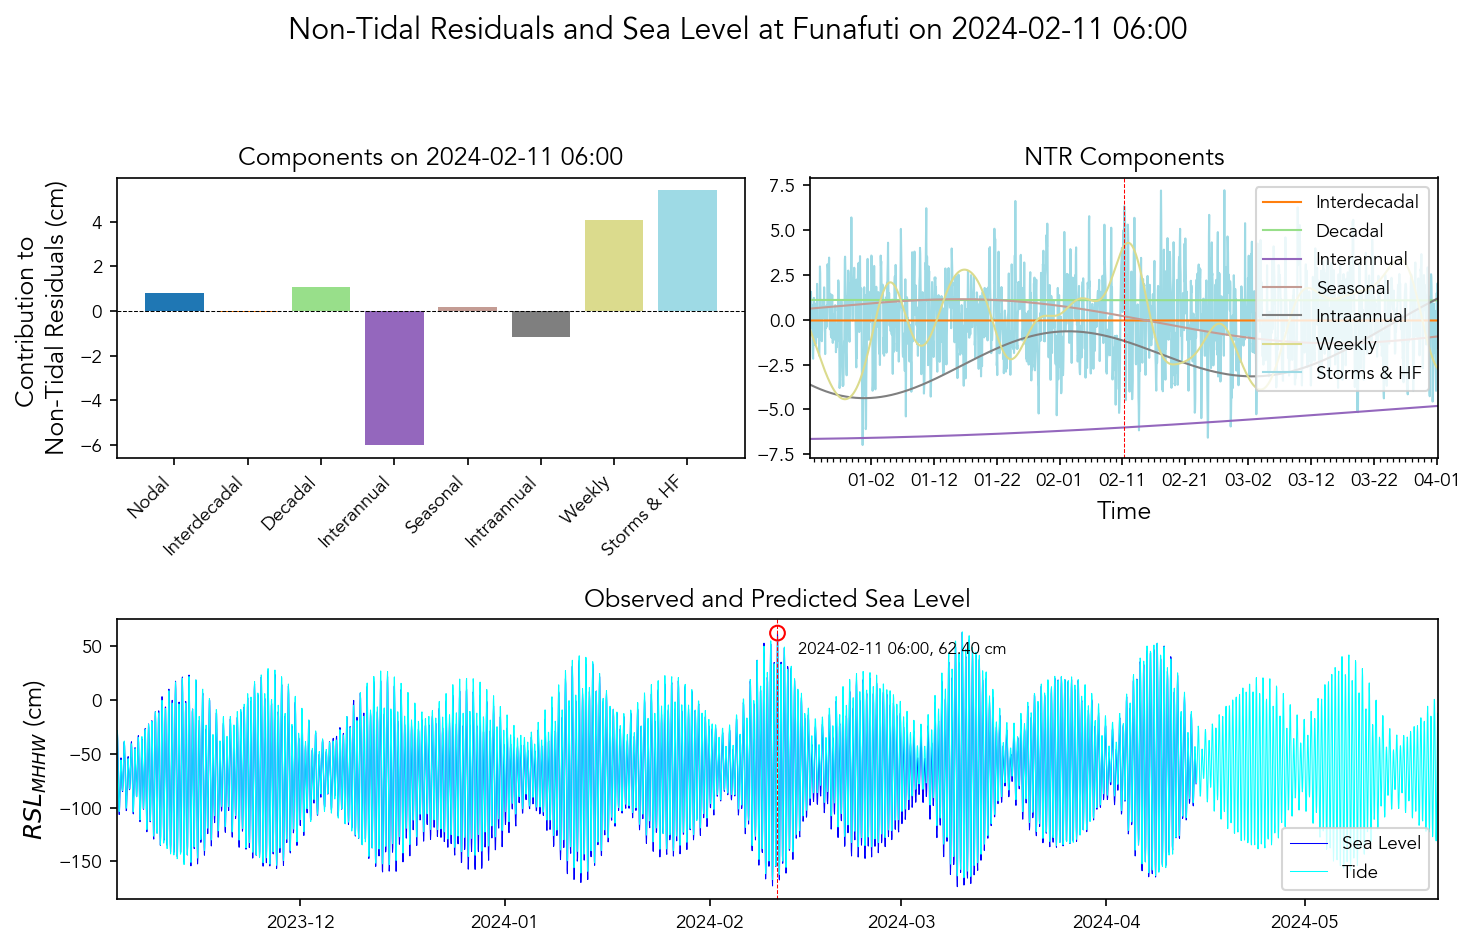

In [57]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

idx = 8

sl_extreme = ntr_filtered_extremes_high['sea_level'].iloc[idx]
dates_to_plot = ntr_filtered_extremes_high['time'].values[idx]
date_str = pd.to_datetime(dates_to_plot).strftime('%Y-%m-%d %H:%M')
data_on_date = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == dates_to_plot]

# Extract the components
components = column_order[4:]
component_values = data_on_date[components].values.flatten()
x_positions = np.arange(len(components))  # Positions for each component


fig, axes = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})

# assign 1 color to each component. There are XX components, so we need XX colors
colors = plt.cm.tab20(np.linspace(0, 1, len(components)))


### --- TOP LEFT PLOT: Bar Chart --- ###
ax = axes[0, 0]  # First row, first column
ax.bar(x_positions, 0.1*component_values, alpha=1, color=colors)
ax.set_xticks(x_positions)
ax.set_xticklabels(components, rotation=45, ha='right')

# Title and labels
ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nNon-Tidal Residuals (cm)')

# Add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)

# Resize subplot width
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])  # Shrink width to 75%

### --- TOP RIGHT PLOT: NTR & Weekly Trends --- ###
ax = axes[0, 1]  # First row, second column

# Filter data to ±10 days around `dates_to_plot`
plusTime = pd.Timedelta('50d')
timespan = pd.date_range(start=dates_to_plot - plusTime, end=dates_to_plot + plusTime, freq='h')

# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)

# Plot NTR and Weekly trends
# ax.plot(data_on_date.index, 0.1*data_on_date['ntr'], label='NTR', color='black', linewidth=0.5)
for col in data_on_date.columns:
    #only do for columns that aren't tide or sea level
    if col not in ['sea_level','tide','NTR','ntr','Nodal','Storms & HF']:
        col_index = components.index(col)
        ax.plot(data_on_date.index, 0.1*data_on_date[col], label=col, color = colors[col_index],linewidth=1)
    if col == 'Storms & HF': #put on the bottom
        col_index = components.index(col)
        ax.plot(data_on_date.index, 0.1*data_on_date[col], label=col, color = colors[col_index],linewidth=1,zorder=0)

ax.axvline(dates_to_plot, color='red', linestyle='--', linewidth=0.5)

#ensure x-axis is readable
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.set_xlim([timespan[0], timespan[-1]])
ax.set_title('NTR Components')
ax.set_xlabel('Time')
ax.legend(loc='upper right')

### --- BOTTOM PLOT: Sea Level, Tide, and Interannual --- ###
fig.delaxes(axes[1, 1])
fig.delaxes(axes[1, 0])
ax = fig.add_subplot(2, 1, 2)

# Filter data to ±100 days around `dates_to_plot`
plusTime = pd.Timedelta('100d')
timespan = pd.date_range(start=dates_to_plot - plusTime, end=dates_to_plot + plusTime, freq='h')

# Ensure time is a datetime index
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)].copy()
data_on_date.set_index('time', inplace=True)

# Plot sea level, tide, and interannual trend
ax.plot(data_on_date.index, 0.1*(data_on_date['sea_level'] - mhhw), label='Sea Level', color='blue', linewidth=0.5)
ax.plot(data_on_date.index, 0.1*(data_on_date['tide'] - mhhw), label='Tide', color='cyan', linewidth=0.5)

ax.set_ylabel('$RSL_{MHHW}$ (cm)')

# Add legend and vertical line
ax.legend(loc='lower right')

# add circle at the date and height
ax.scatter(dates_to_plot, 0.1*(sl_extreme-mhhw), color='red', s=50, zorder=5, facecolors='none')
ax.annotate(f'{date_str}, {0.1*(sl_extreme-mhhw):.2f} cm', 
             (dates_to_plot, 0.1*(sl_extreme-mhhw)), 
             textcoords='offset points', 
             xytext=(10, -10), 
             ha='left', 
             fontsize=8)

ax.axvline(dates_to_plot, color='red', linestyle='--', linewidth=0.5)

# Set x-axis limits
ax.set_xlim([timespan[0], timespan[-1]])
ax.set_title('Observed and Predicted Sea Level')

# add title to entire figure
fig.suptitle('Non-Tidal Residuals and Sea Level at ' + station_name + ' on ' + date_str, y=1.05)

plt.tight_layout()
plt.show()


# save the file to desktop as a png
figName = 'NTR_components_' + station_name + '_' + date_str
glue(figName,fig,display=False)

savepath = Path(output_dir, figName + '.png')
fig.savefig(savepath, dpi=300, bbox_inches='tight')


In [36]:
# We need to treat the tide component differently here to get a better comparison
# get the daily high tides
tide_data = ntr_data['tide']
tide_data.index = ntr_data['time']
tide_max_daily = tide_data.resample('D').max()

tide_max_daily_std = tide_max_daily.std()

tide_min_daily = tide_data.resample('D').min()
tide_min_daily_std = tide_min_daily.std()

In [37]:
ntr_filtered_extremes_high

,time,ntr,sea_level,tide,Nodal,Interdecadal,Decadal,Interannual,Seasonal,Intraannual,Weekly,Storms & HF
69101,2001-02-09 06:00:00,73.670538,3322.0,3262.190631,-5.302147,0.007353,4.991956,46.815780,-6.924379,15.385013,18.560681,-5.165867
69772,2001-03-09 05:00:00,81.720687,3347.0,3279.057141,10.985121,0.027461,6.469103,37.746402,-21.913189,48.465867,15.397742,-4.472700
112685,2006-01-30 06:00:00,128.361105,3358.0,3238.086666,-5.689392,0.369731,14.177308,59.467439,-14.648436,55.018072,-5.000359,18.977350
113380,2006-02-28 05:00:00,118.933257,3415.0,3304.428191,6.249744,0.357765,13.628116,44.379142,-50.343405,76.227061,35.015479,-0.330901
192052,2015-02-19 05:00:00,42.416306,3367.0,3323.173599,10.387990,-1.116672,-10.740951,51.540267,-49.344430,34.913058,-2.280619,19.445654
236357,2020-03-10 06:00:00,34.236708,3369.0,3327.850247,32.106480,-0.567534,24.122365,7.281349,-38.230281,-3.623724,-2.628060,47.882592
237040,2020-04-07 17:00:00,57.130463,3330.0,3265.871659,-4.307749,-0.560882,24.179991,9.902157,-28.724283,46.813079,9.889950,-4.369549
262204,2023-02-20 05:00:00,13.309874,3377.0,3353.566726,-0.329865,-0.440666,12.996469,-0.654401,-6.566955,34.181782,-22.658138,-3.548217
270749,2024-02-11 06:00:00,35.555169,3367.0,3320.260090,8.253583,-0.436306,10.876533,-60.120453,1.906907,-11.828356,40.988127,54.168716
271420,2024-03-10 05:00:00,-16.424270,3373.0,3378.156186,19.628897,-0.436219,10.817098,-53.734408,-12.636099,-27.495356,14.266542,52.794172


In [38]:

def get_relative_component_amps(ntr_filtered_extremes_high, ntr_component_stds, mhhw, tide_max_daily_std):
    """
    Get the relative amplitude of each component in the non-tidal residuals.
    
    Parameters:
    - ntr_filtered_extremes_high: pd.DataFrame, filtered non-tidal residuals for extreme high sea level events
    - ntr_component_stds: pd.Series, standard deviations of each component
    - mhhw: float, mean higher high water value
    - tide_max_daily_std: float, standard deviation of daily high tides
    
    Returns:
    - ntr_filtered_extremes_high_relative_to_std: pd.DataFrame, relative amplitudes of each component
    """
    # make a copy of the filtered extremes
    extremes_high_relative_to_std = ntr_filtered_extremes_high.copy()

    # get the relative amplitude of the tide component
    extremes_high_relative_to_std['tide'] = (ntr_filtered_extremes_high['tide'] - mhhw)/tide_max_daily_std 
    extremes_high_relative_to_std = extremes_high_relative_to_std.drop(columns=['ntr'])

    # for each component, divide by the std
    for component in extremes_high_relative_to_std.columns[3:]:
        extremes_high_relative_to_std[component] = ntr_filtered_extremes_high[component] / ntr_component_stds[component]

    return extremes_high_relative_to_std

extremes_high_relative_to_std = get_relative_component_amps(ntr_filtered_extremes_high, ntr_component_stds, mhhw, tide_max_daily_std)
extremes_low_relative_to_std = get_relative_component_amps(ntr_filtered_extremes_low, ntr_component_stds, mllw, tide_min_daily_std)


In [39]:
def plot_component_amps(extremes_low_relative_to_std, high_or_low = 'high', station_name = ''):
    import matplotlib.colors as mcolors

    # Create heatmap figure
    fig, ax = plt.subplots(figsize=(7, 6))

    #drop the time column and turn it into the index
    extremes_high_relative_to_std_subset = extremes_low_relative_to_std.set_index('time')
    

    cmap = plt.cm.coolwarm
    colors = [(cmap(0.0)),  # Dark blue at -3
              (cmap(0.45)), # Light blue at -1
              (cmap(0.5)),  # White at 0
              (cmap(0.55)), # Light red at 1
              (cmap(1.0))]  # Dark red at 3
    positions = [-3, -1, 0, 1, 3]  # Assigning key points in data range

    # Create a new colormap
    new_cmap = mcolors.LinearSegmentedColormap.from_list("modified_coolwarm", list(zip(np.linspace(0, 1, len(colors)), colors)))

    # Keep a **linear scale** but use the modified colormap
    norm = mcolors.Normalize(vmin=-3, vmax=3)

    # Plot heatmap
    if high_or_low == 'high':
        #order by highest to lowest sea level
        extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.sort_values(by='sea_level', ascending=False)
    if high_or_low == 'low':
        extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.sort_values(by='sea_level', ascending=True)

    # drop sea level column
    extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.drop(columns=['sea_level'])

    heatmap = ax.imshow(extremes_high_relative_to_std_subset.T, cmap=new_cmap, norm=norm,aspect='auto')

    # label rows and columns
    ax.set_xticks(np.arange(len(extremes_high_relative_to_std_subset)))
    ax.set_xticklabels(extremes_high_relative_to_std_subset.index.strftime('%Y-%m-%d %H:%M'),rotation=60, ha='right')
    ax.set_yticks(np.arange(len(extremes_high_relative_to_std_subset.columns)))
    ax.set_yticklabels(extremes_high_relative_to_std_subset.columns)

    # add colorbar, should be same height as heatmap
    cbar = fig.colorbar(heatmap, ax=ax, fraction=0.04, pad=0.04)
    cbar.set_label('Relative Amplitude\n (Standard Deviations)')

    # if high_or_low is high, then "Highest"
    if high_or_low == 'high':
        ax.set_title('Extreme High Sea Level Events:\nRelative Amplitudes of Non-Tidal Residual Components\n' + station_name)
    elif high_or_low == 'low':
        ax.set_title('Extreme Low Sea Level Events:\nRelative Amplitudes of Non-Tidal Residual Components\n' + station_name)

    return fig, ax

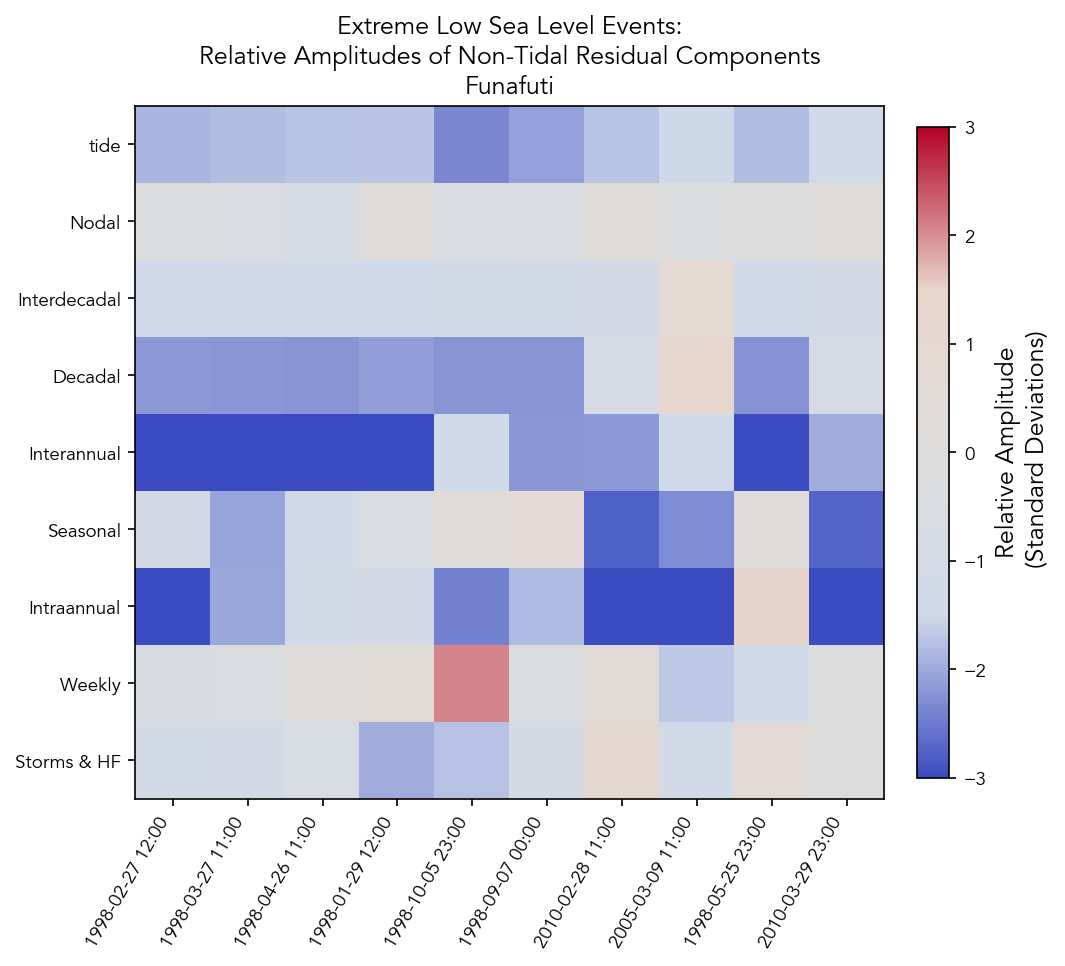

In [40]:
fig,ax = plot_component_amps(extremes_low_relative_to_std, high_or_low = 'low',station_name = station_name)

# save to output
output_path = output_dir / f'SL_rankings_NTR_relative_amplitudes_top10_{station_name}_low.png'
fig.savefig(output_path, bbox_inches='tight')


/Users/jfiedler/Documents/SL_Hawaii_data/output/SL_rankings_NTR_relative_amplitudes_top10_Funafuti_high.png


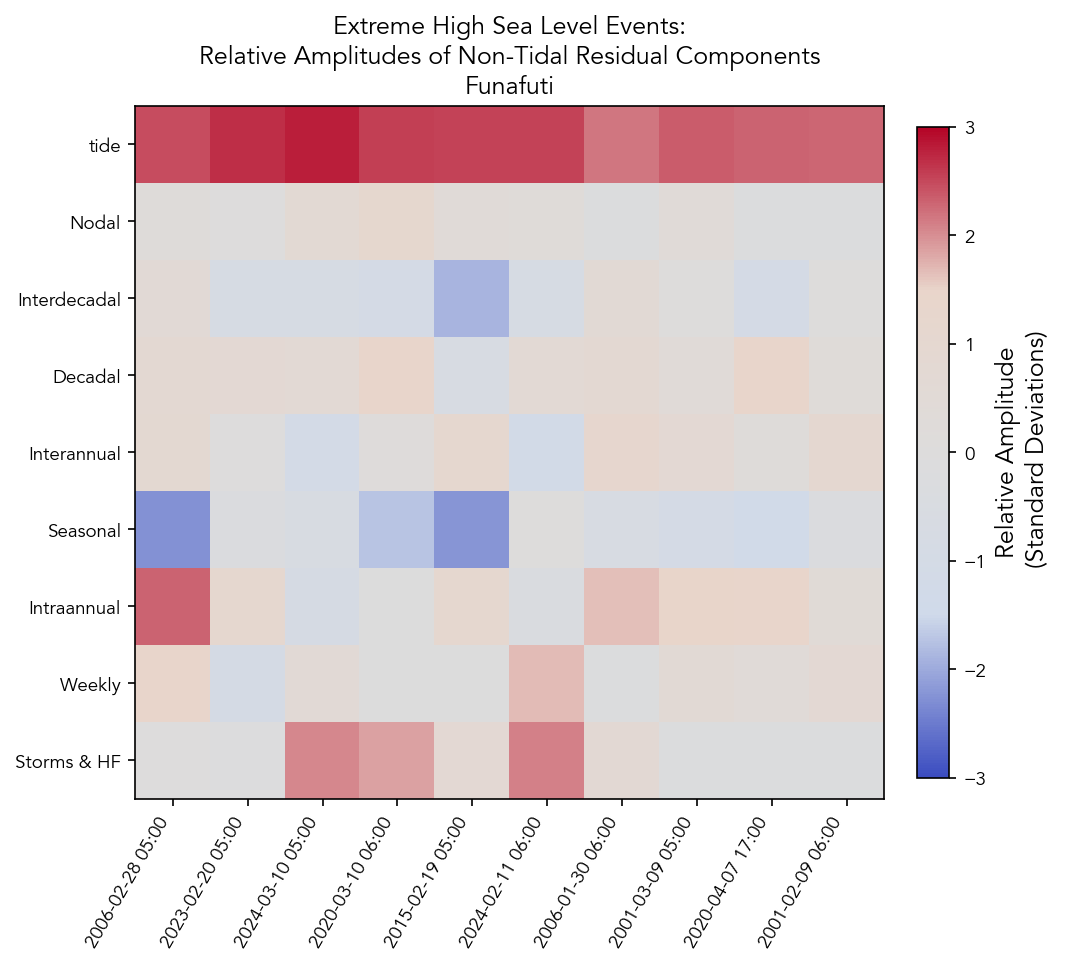

In [41]:
fig, ax = plot_component_amps(extremes_high_relative_to_std, high_or_low = 'high',station_name = station_name)
# save to output
output_path = output_dir / f'SL_rankings_NTR_relative_amplitudes_top10_{station_name}_high.png'

print(output_path)
fig.savefig(output_path, bbox_inches='tight')

## Make a Table


In [42]:
# Now we'll make a nice readable table of the highest and lowest sea level events and their components
# It should be ntr_filtered_extremes_high with the extremes_high_relative_to_std in parentheses

# make a copy of ntr_filtered_extremes_high
extremes_table = ntr_filtered_extremes_high.copy()

# make it relative to mhhw
extremes_table['sea_level'] = extremes_table['sea_level'] - mhhw
extremes_table['tide'] = extremes_table['tide'] - mhhw

# print out only :.2f 
extremes_table = extremes_table.round(2)

#rank according to sea level
extremes_table = extremes_table.sort_values(by='sea_level', ascending=False)
extremes_table




,time,ntr,sea_level,tide,Nodal,Interdecadal,Decadal,Interannual,Seasonal,Intraannual,Weekly,Storms & HF
113380,2006-02-28 05:00:00,118.93,672.0,561.43,6.25,0.36,13.63,44.38,-50.34,76.23,35.02,-0.33
262204,2023-02-20 05:00:00,13.31,634.0,610.57,-0.33,-0.44,13.00,-0.65,-6.57,34.18,-22.66,-3.55
271420,2024-03-10 05:00:00,-16.42,630.0,635.16,19.63,-0.44,10.82,-53.73,-12.64,-27.50,14.27,52.79
236357,2020-03-10 06:00:00,34.24,626.0,584.85,32.11,-0.57,24.12,7.28,-38.23,-3.62,-2.63,47.88
192052,2015-02-19 05:00:00,42.42,624.0,580.17,10.39,-1.12,-10.74,51.54,-49.34,34.91,-2.28,19.45
270749,2024-02-11 06:00:00,35.56,624.0,577.26,8.25,-0.44,10.88,-60.12,1.91,-11.83,40.99,54.17
112685,2006-01-30 06:00:00,128.36,615.0,495.09,-5.69,0.37,14.18,59.47,-14.65,55.02,-5.00,18.98
69772,2001-03-09 05:00:00,81.72,604.0,536.06,10.99,0.03,6.47,37.75,-21.91,48.47,15.40,-4.47
237040,2020-04-07 17:00:00,57.13,587.0,522.87,-4.31,-0.56,24.18,9.90,-28.72,46.81,9.89,-4.37
69101,2001-02-09 06:00:00,73.67,579.0,519.19,-5.30,0.01,4.99,46.82,-6.92,15.39,18.56,-5.17


In [43]:
# check if extremes table everything from interdecadal to storms & hf added equals ntr
extremes_table['sum'] = extremes_table['Interdecadal'] + extremes_table['Decadal'] + extremes_table['Interannual'] + extremes_table['Seasonal'] + extremes_table['Intraannual'] + extremes_table['Weekly'] + extremes_table['Storms & HF']
#print both columns
extremes_table[['ntr','sum']]

,ntr,sum
113380,118.93,118.95
262204,13.31,13.31
271420,-16.42,-16.43
236357,34.24,34.23
192052,42.42,42.42
270749,35.56,35.56
112685,128.36,128.37
69772,81.72,81.74
237040,57.13,57.13
69101,73.67,73.68


In [44]:
# make time the index
# extremes_table = extremes_table.set_index('time')

#change everything except time column to cm
extremes_table.iloc[:,1:] = extremes_table.iloc[:,1:]*0.1

#format time to be more readable
# extremes_table['time'] = extremes_table['time'].dt.strftime('%Y-%m-%d %H:%M')

# round to 2 decimal places
extremes_table = extremes_table.round(1)

extremes_table
# remove sum column
extremes_table = extremes_table.drop(columns='sum')

# put sea_level in first column
extremes_table = extremes_table[['time','sea_level','tide','ntr','Nodal','Interdecadal','Decadal','Interannual','Seasonal','Intraannual','Weekly','Storms & HF']]


In [45]:
extremes_table

,time,sea_level,tide,ntr,Nodal,Interdecadal,Decadal,Interannual,Seasonal,Intraannual,Weekly,Storms & HF
113380,2006-02-28 05:00:00,67.2,56.1,11.9,0.6,0.0,1.4,4.4,-5.0,7.6,3.5,-0.0
262204,2023-02-20 05:00:00,63.4,61.1,1.3,-0.0,-0.0,1.3,-0.1,-0.7,3.4,-2.3,-0.4
271420,2024-03-10 05:00:00,63.0,63.5,-1.6,2.0,-0.0,1.1,-5.4,-1.3,-2.8,1.4,5.3
236357,2020-03-10 06:00:00,62.6,58.5,3.4,3.2,-0.1,2.4,0.7,-3.8,-0.4,-0.3,4.8
192052,2015-02-19 05:00:00,62.4,58.0,4.2,1.0,-0.1,-1.1,5.2,-4.9,3.5,-0.2,1.9
270749,2024-02-11 06:00:00,62.4,57.7,3.6,0.8,-0.0,1.1,-6.0,0.2,-1.2,4.1,5.4
112685,2006-01-30 06:00:00,61.5,49.5,12.8,-0.6,0.0,1.4,5.9,-1.5,5.5,-0.5,1.9
69772,2001-03-09 05:00:00,60.4,53.6,8.2,1.1,0.0,0.6,3.8,-2.2,4.8,1.5,-0.4
237040,2020-04-07 17:00:00,58.7,52.3,5.7,-0.4,-0.1,2.4,1.0,-2.9,4.7,1.0,-0.4
69101,2001-02-09 06:00:00,57.9,51.9,7.4,-0.5,0.0,0.5,4.7,-0.7,1.5,1.9,-0.5


In [46]:
clear formatted_table

In [47]:
# now combine extremes_table with extremes_high_relative_to_std
extremes_table_relative = extremes_table.copy()
extremes_table_relative = extremes_table_relative.set_index('time')
std_table = extremes_high_relative_to_std.copy()
std_table = std_table.set_index('time')

#sort both on sea_level
extremes_table_relative = extremes_table_relative.sort_values(by='sea_level', ascending=False)
std_table = std_table.sort_values(by='sea_level', ascending=False)

extremes_table_relative

# Find common columns
common_columns = extremes_table_relative.columns.intersection(std_table.columns)

# Select only common columns from both tables
extremes_common = extremes_table_relative[common_columns]
std_common = std_table[common_columns]

# Rename std columns to make them distinct
std_common = std_common.rename(columns={col: f"{col}_std" for col in common_columns})

# Interleave columns (merge column-by-column)
interleaved_columns = sum(zip(extremes_common.columns, std_common.columns), ())  # Creates interleaved column order

# Combine the tables, ensuring interleaved order
formatted_table = pd.concat([extremes_common, std_common], axis=1)[list(interleaved_columns)]

# Add back 'sea_level' and 'ntr' at the front
formatted_table = pd.concat([extremes_table_relative[['sea_level', 'ntr']], formatted_table], axis=1)

#drop sea_level_std column
formatted_table = formatted_table.drop(columns=['sea_level_std','sea_level'])

# add 'sea level' column back in front
formatted_table.insert(0, 'sea_level', extremes_table_relative['sea_level'])

# format all to 1 decimal place
formatted_table = formatted_table.round(1)

formatted_table


,sea_level,ntr,tide,tide_std,Nodal,Nodal_std,Interdecadal,Interdecadal_std,Decadal,Decadal_std,Interannual,Interannual_std,Seasonal,Seasonal_std,Intraannual,Intraannual_std,Weekly,Weekly_std,Storms & HF,Storms & HF_std
time,,,,,,,,,,,,,,,,,,,,
2006-02-28 05:00:00,67.2,11.9,56.1,2.5,0.6,0.2,0.0,0.6,1.4,0.8,4.4,0.9,-5.0,-2.3,7.6,2.3,3.5,1.4,-0.0,-0.0
2023-02-20 05:00:00,63.4,1.3,61.1,2.7,-0.0,-0.0,-0.0,-0.7,1.3,0.8,-0.1,-0.0,-0.7,-0.3,3.4,1.0,-2.3,-0.9,-0.4,-0.1
2024-03-10 05:00:00,63.0,-1.6,63.5,2.8,2.0,0.7,-0.0,-0.7,1.1,0.6,-5.4,-1.1,-1.3,-0.6,-2.8,-0.8,1.4,0.6,5.3,2.1
2020-03-10 06:00:00,62.6,3.4,58.5,2.6,3.2,1.1,-0.1,-1.0,2.4,1.4,0.7,0.1,-3.8,-1.7,-0.4,-0.1,-0.3,-0.1,4.8,1.9
2015-02-19 05:00:00,62.4,4.2,58.0,2.6,1.0,0.4,-0.1,-1.9,-1.1,-0.6,5.2,1.0,-4.9,-2.2,3.5,1.1,-0.2,-0.1,1.9,0.8
2024-02-11 06:00:00,62.4,3.6,57.7,2.5,0.8,0.3,-0.0,-0.7,1.1,0.6,-6.0,-1.2,0.2,0.1,-1.2,-0.4,4.1,1.7,5.4,2.1
2006-01-30 06:00:00,61.5,12.8,49.5,2.2,-0.6,-0.2,0.0,0.6,1.4,0.8,5.9,1.2,-1.5,-0.7,5.5,1.7,-0.5,-0.2,1.9,0.7
2001-03-09 05:00:00,60.4,8.2,53.6,2.4,1.1,0.4,0.0,0.0,0.6,0.4,3.8,0.8,-2.2,-1.0,4.8,1.5,1.5,0.6,-0.4,-0.2
2020-04-07 17:00:00,58.7,5.7,52.3,2.3,-0.4,-0.2,-0.1,-0.9,2.4,1.4,1.0,0.2,-2.9,-1.3,4.7,1.4,1.0,0.4,-0.4,-0.2


In [48]:
#make a pretty pdf of the table with great_tables
from great_tables import GT, html, style, loc

# make time a column again
formatted_table_time = formatted_table.reset_index()
# make time a string
formatted_table_time['time'] = formatted_table_time['time'].dt.strftime('%Y-%m-%d %H:%M')

#change 'Storms & HF_std' to 'Storms_std'
formatted_table_time = formatted_table_time.rename(columns={'Storms & HF_std': 'Storms_std'})

ntr_columns = ['Interdecadal','Interdecadal_std',
               'Decadal','Decadal_std',
               'Interannual','Interannual_std',
               'Seasonal','Seasonal_std',
               'Intraannual','Intraannual_std',
               'Weekly','Weekly_std',
               'Storms & HF','Storms_std']

# col_width_dict = #make dictionary using ntr_columns
col_width_dict = {col: "30px" for col in ntr_columns}
#add time to col_width_dict
col_width_dict['time'] = "120px"

std_columns = [col for col in formatted_table_time.columns if 'std' in col]

# Create a Table object
(
    GT(formatted_table_time)
    .tab_options(table_font_size="12px")
    .cols_width(cases={"time" : "150px"})
    .cols_label(
        time = html(''),
        ntr=html('NTR'), sea_level=html('Sea Level'), tide_std=html('(σ̂)'),Interdecadal = html('Inter-\ndecadal'),Interdecadal_std=html('(σ̂)'),
        Decadal_std=html('(σ̂)'),Interannual_std=html('(σ̂)'), Interannual=html('Inter-\nannual'),
        Seasonal_std=html('(σ̂)'),Intraannual_std=html('(σ̂)'),Intraannual=html('Intra-\nannual'),
        Weekly_std=html('(σ̂)'),Storms_std=html('(σ̂)'),Nodal_std = html('(σ̂)'),
        tide=html('Tide'))
        .tab_spanner(
            label="Non-Tidal Residual", columns=ntr_columns)
        .tab_header(
            title=station_name,subtitle='Top 10 Extreme Sea Level Events and their Non-Tidal Residual Components')
        .tab_source_note(
            source_note='Data are in cm, relative to MHHW. The (σ̂) represents the magnitude of each component relative to its standard deviation.')
        .tab_source_note(
            source_note='Data: ' +ds.attrs['title'] + ', ' + ds.attrs['publisher_url'] + ', ' + 'UHSLC Station ID: ' + str(station))
        .fmt_number(
            columns=std_columns, pattern='({x})',decimals=1)
        .data_color(columns=std_columns, palette='RdBu',reverse=True,domain=(-4,4),alpha=0.5)

)


GT(_tbl_data=               time  sea_level   ntr  tide  tide_std  Nodal  Nodal_std  \
0  2006-02-28 05:00       67.2  11.9  56.1       2.5    0.6        0.2   
1  2023-02-20 05:00       63.4   1.3  61.1       2.7   -0.0       -0.0   
2  2024-03-10 05:00       63.0  -1.6  63.5       2.8    2.0        0.7   
3  2020-03-10 06:00       62.6   3.4  58.5       2.6    3.2        1.1   
4  2015-02-19 05:00       62.4   4.2  58.0       2.6    1.0        0.4   
5  2024-02-11 06:00       62.4   3.6  57.7       2.5    0.8        0.3   
6  2006-01-30 06:00       61.5  12.8  49.5       2.2   -0.6       -0.2   
7  2001-03-09 05:00       60.4   8.2  53.6       2.4    1.1        0.4   
8  2020-04-07 17:00       58.7   5.7  52.3       2.3   -0.4       -0.2   
9  2001-02-09 06:00       57.9   7.4  51.9       2.3   -0.5       -0.2   

   Interdecadal  Interdecadal_std  Decadal  ...  Interannual  Interannual_std  \
0           0.0               0.6      1.4  ...          4.4              0.9   
1          -0.0              -0.7      1.3  ...         -0.1             -0.0   
2          -0.0              -0.7      1.1  ...         -5.4             -1.1   
3          -0.1              -1.0      2.4  ...          0.7              0.1   
4          -0.1              -1.9     -1.1  ...          5.2              1.0   
5          -0.0              -0.7      1.1  ...         -6.0             -1.2   
6           0.0               0.6      1.4  ...          5.9              1.2   
7           0.0               0.0      0.6  ...          3.8              0.8   
8          -0.1              -0.9      2.4  ...          1.0              0.2   
9           0.0               0.0      0.5  ...          4.7              0.9   

   Seasonal  Seasonal_std  Intraannual  Intraannual_std  Weekly  Weekly_std  \
0      -5.0          -2.3          7.6              2.3     3.5         1.4   
1      -0.7          -0.3          3.4              1.0    -2.3        -0.9   
2      -1.3          -0.6         -2.8             -0.8     1.4         0.6   
3      -3.8          -1.7         -0.4             -0.1    -0.3        -0.1   
4      -4.9          -2.2          3.5              1.1    -0.2        -0.1   
5       0.2           0.1         -1.2             -0.4     4.1         1.7   
6      -1.5          -0.7          5.5              1.7    -0.5        -0.2   
7      -2.2          -1.0          4.8              1.5     1.5         0.6   
8      -2.9          -1.3          4.7              1.4     1.0         0.4   
9      -0.7          -0.3          1.5              0.5     1.9         0.8   

   Storms & HF  Storms_std  
0         -0.0        -0.0  
1         -0.4        -0.1  
2          5.3         2.1  
3          4.8         1.9  
4          1.9         0.8  
5          5.4         2.1  
6          1.9         0.7  
7         -0.4        -0.2  
8         -0.4        -0.2  
9         -0.5        -0.2  

[10 rows x 21 columns], _body=<great_tables._gt_data.Body object at 0x30d8b0760>, _boxhead=Boxhead([ColInfo(var='time', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text=''), column_align='right', column_width='150px'), ColInfo(var='sea_level', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Sea Level'), column_align='right', column_width=None), ColInfo(var='ntr', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='NTR'), column_align='right', column_width=None), ColInfo(var='tide', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Tide'), column_align='right', column_width=None), ColInfo(var='tide_std', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='(σ̂)'), column_align='right', column_width=None), ColInfo(var='Nodal', type=<ColInfoTypeEnum.default: 1>, column_label='Nodal', column_align='right', column_width=None), ColInfo(var='Nodal_std', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='(σ̂)'), column_align='right', column_width=None), ColInfo(var='Interdecadal', type=<ColInfoTypeEnum.default: 1>, column_label=Html

This table is trying to be the best at both worlds but is probably too complicated. A simpler version:

In [49]:
# make time a column again
formatted_table_time = extremes_table_relative.reset_index()
# make time a string
formatted_table_time['time'] = formatted_table_time['time'].dt.strftime('%Y-%m-%d %H:%M')


ntr_columns = ['Interdecadal',
               'Decadal',
               'Interannual',
               'Seasonal',
               'Intraannual',
               'Weekly',
               'Storms & HF']

# col_width_dict = #make dictionary using ntr_columns
col_width_dict = {col: "5%" for col in ntr_columns}
#add time to col_width_dict
# col_width_dict['time'] = "120px"

std_columns = [col for col in formatted_table_time.columns if 'std' in col]

timeframes_str = "; ".join([f"{k}: {v}" for k, v in timeframes.items()])

# Create a Table object
(
    GT(formatted_table_time)
    .tab_options(table_font_size="13px")
    .cols_width(cases={"time": "150px"})
    .cols_label(
        time = html(''),
        ntr=html('NTR'), sea_level=html('Sea Level'), Interdecadal = html('Inter-\ndecadal'),
        Interannual=html('Inter-\nannual'),Intraannual=html('Intra-\nannual'),
        tide=html('Tide'))
        .tab_spanner(
            label="Non-Tidal Residual", columns=ntr_columns)
        .tab_header(
            title=station_name,subtitle='Top 10 Extreme Sea Level Events and their Non-Tidal Residual Components')
        .tab_source_note(
            source_note='Data are in cm, relative to MHHW. '
            'The Nodal component shown here is included in the Tide component, representing the nodal modulation of the tide at the given hour. '
            'The timescales of the NTR components are as follows: ' + timeframes_str + '.')
            
        .tab_source_note(
            source_note='Data: ' +ds.attrs['title'] + ', ' + ds.attrs['publisher_url'] + ', ' + 'UHSLC Station ID: ' + str(station))
        .fmt_number(
            columns=std_columns, pattern='({x})',decimals=1)
        .data_color(columns=std_columns, palette='RdBu',reverse=True,domain=(-4,4),alpha=0.5)
)

GT(_tbl_data=               time  sea_level  tide   ntr  Nodal  Interdecadal  Decadal  \
0  2006-02-28 05:00       67.2  56.1  11.9    0.6           0.0      1.4   
1  2023-02-20 05:00       63.4  61.1   1.3   -0.0          -0.0      1.3   
2  2024-03-10 05:00       63.0  63.5  -1.6    2.0          -0.0      1.1   
3  2020-03-10 06:00       62.6  58.5   3.4    3.2          -0.1      2.4   
4  2015-02-19 05:00       62.4  58.0   4.2    1.0          -0.1     -1.1   
5  2024-02-11 06:00       62.4  57.7   3.6    0.8          -0.0      1.1   
6  2006-01-30 06:00       61.5  49.5  12.8   -0.6           0.0      1.4   
7  2001-03-09 05:00       60.4  53.6   8.2    1.1           0.0      0.6   
8  2020-04-07 17:00       58.7  52.3   5.7   -0.4          -0.1      2.4   
9  2001-02-09 06:00       57.9  51.9   7.4   -0.5           0.0      0.5   

   Interannual  Seasonal  Intraannual  Weekly  Storms & HF  
0          4.4      -5.0          7.6     3.5         -0.0  
1         -0.1      -0.7          3.4    -2.3         -0.4  
2         -5.4      -1.3         -2.8     1.4          5.3  
3          0.7      -3.8         -0.4    -0.3          4.8  
4          5.2      -4.9          3.5    -0.2          1.9  
5         -6.0       0.2         -1.2     4.1          5.4  
6          5.9      -1.5          5.5    -0.5          1.9  
7          3.8      -2.2          4.8     1.5         -0.4  
8          1.0      -2.9          4.7     1.0         -0.4  
9          4.7      -0.7          1.5     1.9         -0.5  , _body=<great_tables._gt_data.Body object at 0x177f68340>, _boxhead=Boxhead([ColInfo(var='time', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text=''), column_align='right', column_width='150px'), ColInfo(var='sea_level', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Sea Level'), column_align='right', column_width=None), ColInfo(var='tide', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Tide'), column_align='right', column_width=None), ColInfo(var='ntr', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='NTR'), column_align='right', column_width=None), ColInfo(var='Nodal', type=<ColInfoTypeEnum.default: 1>, column_label='Nodal', column_align='right', column_width=None), ColInfo(var='Interdecadal', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Inter-\ndecadal'), column_align='right', column_width=None), ColInfo(var='Decadal', type=<ColInfoTypeEnum.default: 1>, column_label='Decadal', column_align='right', column_width=None), ColInfo(var='Interannual', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Inter-\nannual'), column_align='right', column_width=None), ColInfo(var='Seasonal', type=<ColInfoTypeEnum.default: 1>, column_label='Seasonal', column_align='right', column_width=None), ColInfo(var='Intraannual', type=<ColInfoTypeEnum.default: 1>, column_label=Html(text='Intra-\nannual'), column_align='right', column_width=None), ColInfo(var='Weekly', type=<ColInfoTypeEnum.default: 1>, column_label='Weekly', column_align='right', column_width=None), ColInfo(var='Storms & HF', type=<ColInfoTypeEnum.default: 1>, column_label='Storms & HF', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x177f4cb80>, _spanners=Spanners([SpannerInfo(spanner_id='Non-Tidal Residual', spanner_level=0, spanner_label='Non-Tidal Residual', spanner_units=None, spanner_pattern=None, vars=['Interdecadal', 'Decadal', 'Interannual', 'Seasonal', 'Intraannual', 'Weekly', 'Storms & HF'], built=None)]), _heading=Heading(title='Funafuti', subtitle='Top 10 Extreme Sea Level Events and their Non-Tidal Residual Components', preheader=None), _stubhead=None, _source_notes=['Data are in cm, relative to MHHW. The Nodal component shown here is included in the Tide component, representing the nodal modulation of the tide at the given hour. The timescales of the NTR components are as follows: Interdecadal: >30 yr cycles; Decadal: e.g. PDO, 8-30 yr; Seasonal: Annual, Semi-Annual, Qtr-A

## Make a map

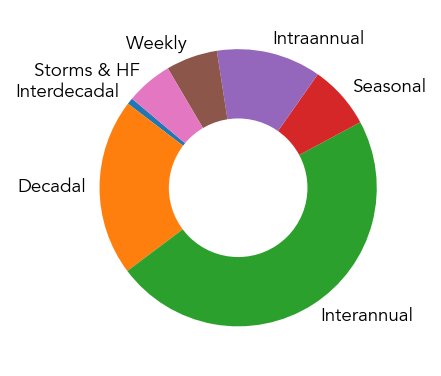

In [50]:
# let's turn our our bar chart into a pie chart
# we'll use what we used previously to get the std of each component
# ntr_cumsum_stds
# ntr_var = ntr_filtered['ntr'].var()

# ntr_component_vars['covariance'] = ntr_var - sum_ntr_var

# get the difference between each successive component
ntr_cumsum_diff = ntr_cumsum_stds.diff()

ntr_cumsum_diff['Interdecadal'] = ntr_cumsum_stds['Interdecadal']

#reverse the order of the components
# ntr_cumsum_stds = ntr_cumsum_stds[::-1]
# ntr_component_vars = ntr_component_vars[::-1]

# # make a pie chart, ignoring co-variance for now because omg
fig, ax = plt.subplots(figsize=(3,3))
ax.pie(ntr_cumsum_diff, labels=ntr_cumsum_diff.index, startangle=140)
center_circle = plt.Circle((0, 0), 0.5, fc='white')  # Creates a white hole
ax.add_patch(center_circle)



In [51]:
# make a locations dictionary, with stations: (lat, lon)
# from ds
stations = ds['station_name'].values
lons = ds['lon'].values
lats = ds['lat'].values
station_id = ds['record_id'].values

locations = {station: (lon,lat) for station, lat, lon in zip(stations, lats, lons)}
station_ids = {station: id for station, id in zip(stations, station_id)}

# make pie_data dictionary
ntr_component_stds_subset = ntr_component_stds.copy()
ntr_component_stds_subset = ntr_component_stds_subset.drop(['sea_level', 'tide'])
pie_data = {station: ntr_component_stds_subset for station in stations}


locations
station_ids

{'Funafuti': 25, "Nuku'alofa": 38}

In [52]:
# make a new pie data dictionary that calls from ntr_data/ntr_{station:03d}_component_stds.csv
pie_data = {}
ntr_mag = {}
for station, id in station_ids.items():
    station_path = Path(data_dir, f'ntr_data/ntr_{id:03d}_component_stds.csv')
    if not station_path.exists():
        # pie_data[station] = zeros the size of ntr_component_stds
        pie_data[station] = ntr_component_stds * 0
        continue
    station_data = pd.read_csv(station_path, index_col=0)
    if 'ntr' in station_data.index:
        ntr_mag[station] = station_data.loc['ntr'].values[0]
        station_data = station_data.drop(index='ntr')
    # print(station_data)
    # ntr_mag[station] = station_data['ntr']
    station_data = station_data.drop(index=['sea_level','tide'])
    # remove 'sea_level' and 'tide' columns
    pie_data[station] = station_data.squeeze()



Text(0.5, 1.0, 'Non-Tidal Residual Component Beachballs by Station')

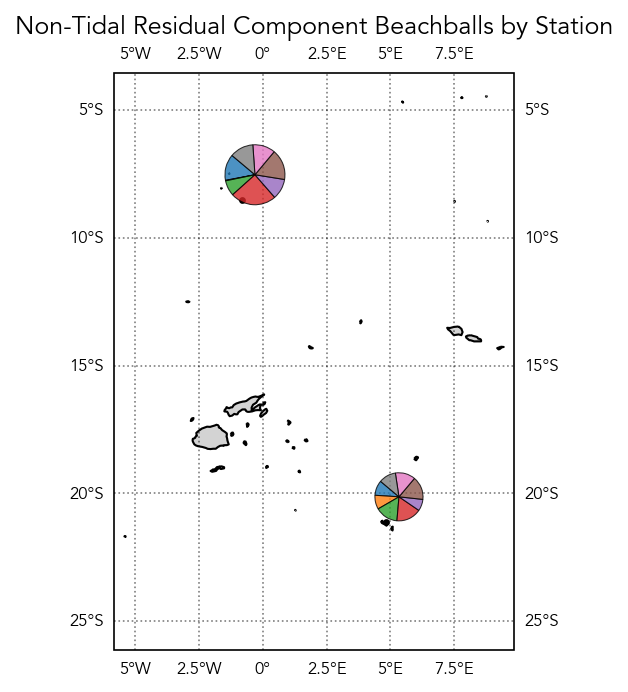

In [53]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

crs = ccrs.PlateCarree(central_longitude=180)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,5), subplot_kw={'projection': crs})
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, color='lightgrey')

# cmems = xr.open_dataset(data_dir / 'cmems_L4_SSH_0.125deg_1993_2024.nc')

xlims = [ds['lon'].min()-5, ds['lon'].max()+5]
ylims = [ds['lat'].min()-5, ds['lat'].max()+5]
xlims_360 = [x + 360 if x < 0 else x for x in xlims]

ax.set_extent([xlims_360[0], xlims_360[1], ylims[0], ylims[1]], crs=ccrs.PlateCarree())

def plot_pie_inset(data, lon, lat, station, ax, width, alpha=1):
    # Convert lat/lon to map display coordinates
    x, y = ax.projection.transform_point(lon, lat, ccrs.PlateCarree())[:2]
    y = y + 1 
    x = x + 0.5
    pie_ax = inset_axes(ax, width=width, height=width, loc=10, 
                        bbox_to_anchor=(x, y), bbox_transform=ax.transData, borderpad=0)
    pie_ax.set_facecolor('none')  # Fully transparent background

    wedges, texts, autotexts = pie_ax.pie(data, autopct='',startangle=140, 
                                          wedgeprops={'alpha': 0.8, 'edgecolor': 'black', 'linewidth': 0.5})
    
    # pie_ax.pie(data, startangle=140)  # Draw pie chart
    pie_ax.set_xticks([])
    pie_ax.set_yticks([])
    pie_ax.set_frame_on(False)  # Hide frame
    # add title
    # pie_ax.set_title(station, fontsize=8)

for station, data in pie_data.items():
    lon, lat = locations[station]
    # if data is all zeros, skip
    if np.all(data == 0):
        continue
    width = 0.5*(ntr_mag[station]/max(ntr_mag.values()))

    plot_pie_inset(data, lon, lat, station,ax, width=width)

ax.scatter(lons, lats, color='black', s=5, label='Station', transform=ccrs.PlateCarree())


#add grid
gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                  alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks(),crs=crs)
#make all labels tiny
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}


# Will need to fix longitude labels!!
ax.set_title('Non-Tidal Residual Component Beachballs by Station')


In [54]:
# # make a new pie data dictionary that calls from ntr_data/ntr_{station:03d}_component_stds.csv
# pie_data = {}

# make a dataframe of the ntr_component_stds, with each station as a column
ntr_component_stds_df = pd.DataFrame(columns=stations)
# ntr_component_stds_df = ntr_component_stds_df.append(ntr_component_stds, ignore_index=True)
for station, id in station_ids.items():
    station_path = Path(data_dir, f'ntr_data/ntr_{id:03d}_component_stds.csv')
    if not station_path.exists():
#         # pie_data[station] = zeros the size of ntr_component_stds
        pie_data[station] = ntr_component_stds * 0
        continue
    station_data = pd.read_csv(station_path, index_col=0)
    ntr_component_stds_df[station] = station_data.squeeze()

#replace nans with 0
ntr_component_stds_df = ntr_component_stds_df.fillna(0).infer_objects(copy=False)
#change 'tide' to 'Tide' in index
ntr_component_stds_df = ntr_component_stds_df.rename(index={'tide':'Tide'})

In [55]:
ntr_component_stds_df

,Funafuti,Nuku'alofa
ntr,80.312141,64.384297
sea_level,475.137279,394.176600
Tide,470.282670,391.562621
Nodal,28.348202,18.821874
Interdecadal,0.591677,17.508222
Decadal,16.825801,28.524170
Interannual,49.896996,31.384168
Seasonal,22.225112,14.598238
Intraannual,33.136991,29.098722
Weekly,24.530909,25.229519


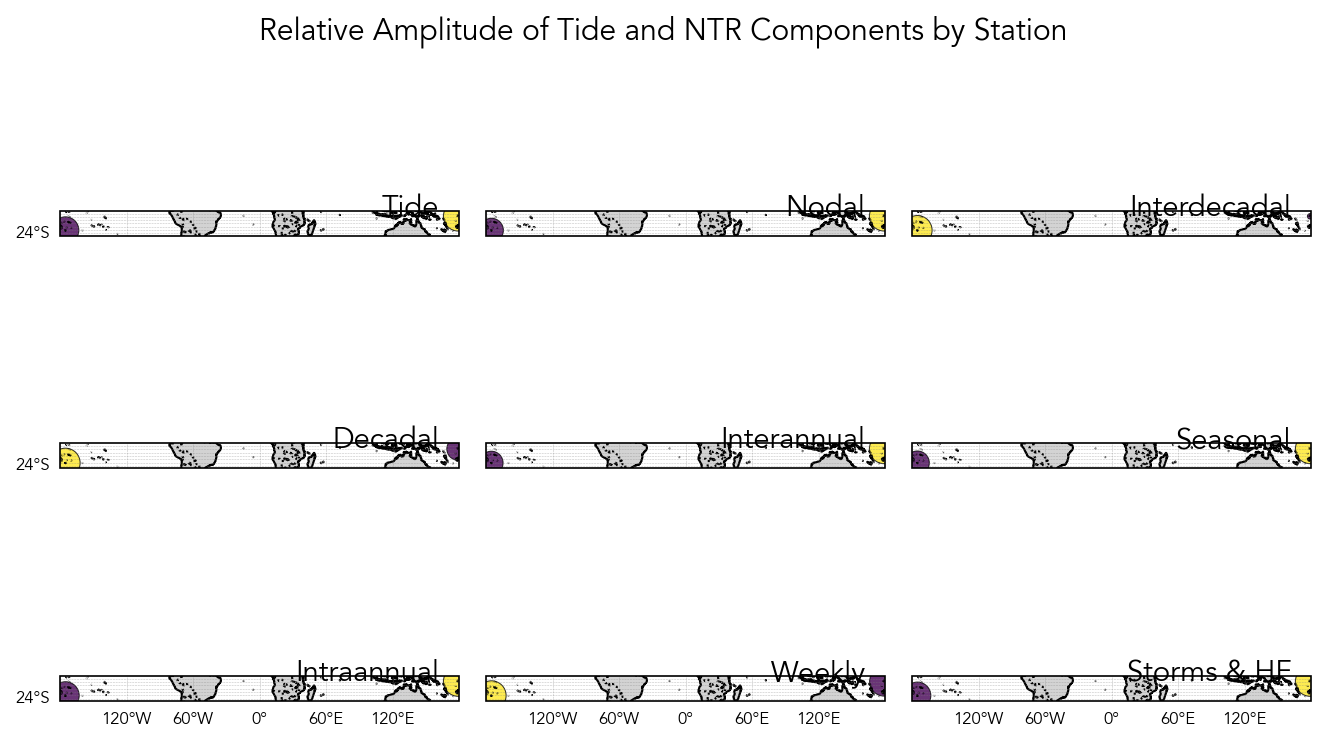

In [56]:
#Repeat the map exercise using only the amplitudes of each component at each station, will just be a scatter plot
from maps import plot_thin_map_hawaii, get_stationinfo

fig, ax = plt.subplots(3, 3, figsize=(9, 6), subplot_kw={'projection': ccrs.PlateCarree()})

ntr_component_names = ntr_component_stds_df.index
#remove sea level and ntr
ntr_component_names = ntr_component_names.drop(['sea_level','ntr'])

colors = plt.cm.tab20(np.linspace(0, 1, len(ntr_component_names)))

for i,ax in enumerate(ax.flat):
    ax,gl = plot_thin_map_hawaii(ax) ## THIN MAP HAWAII IS YOUR FIRST MISTAKE, THIS WON'T WORK FOR TONGA FRIEND

    # crs = ccrs.PlateCarree(central_longitude=180)

    xlims = [ds['lon'].min()-50, ds['lon'].max()+50]
    ylims = [ds['lat'].min()-5, ds['lat'].max()+5]

    ax.set_extent([xlims[0], xlims[1], ylims[0], ylims[1]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, color='lightgrey')

    ntrmag = ntr_component_stds_df.loc[ntr_component_names[i]]
    ntrmagNorm = ntrmag/ntrmag.max()
    ax.scatter(lons, lats, s=200*ntrmagNorm, c = ntrmagNorm, alpha=0.8,
                transform=ccrs.PlateCarree(), linewidth=0.5, edgecolor='black')
    
    # add label for station name in upper right
    ax.text(0.95, 0.8, ntr_component_names[i], fontsize=14, ha='right', transform=ax.transAxes)
    
    #remove gl labels from interior plots
    if i % 3 != 0:
        gl.right_labels = False
        gl.left_labels = False

    if i < 6:
        gl.top_labels = False
        gl.bottom_labels = False

    if i%3 == 0:
        gl.right_labels = False

    if i>=6:
        gl.top_labels = False

plt.tight_layout()
#adjust 
# add title
fig.suptitle('Relative Amplitude of Tide and NTR Components by Station')

# suptitle should be higher
plt.subplots_adjust(top=0.95)

